In [2]:
!pip install --disable-pip-version-check -q awswrangler==2.14.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.


In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [4]:
import boto3
import sagemaker
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve
from sagemaker.transformer import Transformer
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
from pyathena import connect

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as cm
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc

import io
from time import gmtime, strftime, time
import re
import warnings

# Ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
prefix = 'olist_review_score'

s3 = boto3.resource('s3')
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.client("s3", region_name=region)

featurestore_runtime = boto3.Session().client(service_name='sagemaker-featurestore-runtime', region_name=region)
feature_store_session = Session(
    boto_session=boto3.Session(region_name=region),
    sagemaker_client=sm,
    sagemaker_featurestore_runtime_client=featurestore_runtime,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Store Data into S3 Data Lake ##

In [5]:
s3_source_path_csvs = "/root/OlistEcommerce/ProjectDataset/"
print(s3_source_path_csvs)

/root/OlistEcommerce/ProjectDataset/


In [6]:
s3_destination_path_csv = "s3://{}/FinalProjectDataset/csv".format(bucket)
print(s3_destination_path_csv)

s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv


In [7]:
!aws s3 cp $s3_source_path_csvs $s3_destination_path_csv/ --recursive --exclude "*" --include "*.csv"

upload: ProjectDataset/olist_order_payments_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_payments_dataset.csv
upload: ProjectDataset/olist_customers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_customers_dataset.csv
upload: ProjectDataset/product_category_name_translation.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/product_category_name_translation.csv
upload: ProjectDataset/olist_sellers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_sellers_dataset.csv
upload: ProjectDataset/olist_geolocation_dataset2.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_geolocation_dataset2.csv
upload: ProjectDataset/olist_order_items_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_items_dataset.csv
upload: ProjectDataset/olist_orders_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjec

In [8]:
# Confirm that all data was uploaded
!aws s3 ls $s3_destination_path_csv/

                           PRE /
2024-06-03 21:06:08    9033957 olist_customers_dataset.csv
2024-06-03 21:06:08   23400724 olist_geolocation_dataset1.csv
2024-06-03 21:06:08   23582346 olist_geolocation_dataset2.csv
2024-06-03 21:06:08   15438671 olist_order_items_dataset.csv
2024-06-03 21:06:09    5777138 olist_order_payments_dataset.csv
2024-06-03 21:06:09   14451670 olist_order_reviews_dataset.csv
2024-06-03 21:06:09   17654914 olist_orders_dataset.csv
2024-06-03 21:06:10    2379446 olist_products_dataset.csv
2024-06-03 21:06:09     174703 olist_sellers_dataset.csv
2024-06-03 21:06:09       2613 product_category_name_translation.csv


## Setup PyAthena ##

In [9]:
db_name = "olist_ecommerce_aws"

In [10]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
print(s3_staging_dir)

s3://sagemaker-us-east-1-757088774357/athena/staging


In [11]:
# Establish Connection to Athena Staging Directory in S3
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
# Create the Olist Ecommerce AWS DB if One Does not Exist
statement = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(statement, conn)

""


In [13]:
# Ensure DB Now Exists or Already Existed
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,olist_ecommerce_aws
2,sagemaker_featurestore


### Create Table in PyAthena ###

In [14]:
### NOTE: Skipped for Now

## Perform EDA Using Data Lake ##

In [15]:
print(bucket)

sagemaker-us-east-1-757088774357


In [16]:
customer_data_object = s3_client.get_object(Bucket=bucket, Key=
    "FinalProjectDataset/csv/olist_customers_dataset.csv"
)
geolocation_data_object1 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset1.csv"
))
geolocation_data_object2 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset2.csv"
))
items_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_items_dataset.csv"
))
order_payments_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_payments_dataset.csv"
))
order_reviews_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_reviews_dataset.csv"
))
orders_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_orders_dataset.csv"
))
products_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_products_dataset.csv"
))
sellers_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_sellers_dataset.csv"
))
product_category_name_translation_data_object= s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/product_category_name_translation.csv"
))

customer_data = pd.read_csv(io.BytesIO(customer_data_object["Body"].read()))
geolocation_data1 = pd.read_csv(io.BytesIO(geolocation_data_object1["Body"].read()))
geolocation_data2 = pd.read_csv(io.BytesIO(geolocation_data_object2["Body"].read()))
order_items_data = pd.read_csv(io.BytesIO(items_data_object["Body"].read()))
order_payments_data = pd.read_csv(io.BytesIO(order_payments_data_object["Body"].read()))
order_reviews_data = pd.read_csv(io.BytesIO(order_reviews_data_object["Body"].read()))
orders_data = pd.read_csv(io.BytesIO(orders_data_object["Body"].read()))
products_data = pd.read_csv(io.BytesIO(products_data_object["Body"].read()))
sellers_data = pd.read_csv(io.BytesIO(sellers_data_object["Body"].read()))
product_category_name_translation_data = pd.read_csv(io.BytesIO(product_category_name_translation_data_object["Body"].read()))

In [17]:
# List of DataFrame names
dataframe_names = [
    "customer_data", "geolocation_data1", "geolocation_data2", "order_items_data", "order_payments_data",
    "order_reviews_data", "orders_data", "products_data", "sellers_data", "product_category_name_translation_data"
]

# Iterate over DataFrame names and print the head of each DataFrame to Ensure Data is Captured
for df_name in dataframe_names:
    print(f"Head of DataFrame: {df_name}")
    print(eval(df_name).head(5))  # Print the head of each DataFrame
    print("\n")

Head of DataFrame: customer_data
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


Head of DataFrame: geolocation_data1
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0            

In [18]:
print(dataframe_names)

['customer_data', 'geolocation_data1', 'geolocation_data2', 'order_items_data', 'order_payments_data', 'order_reviews_data', 'orders_data', 'products_data', 'sellers_data', 'product_category_name_translation_data']


In [19]:
products_data.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [20]:
product_catagory_count=products_data.groupby('product_category_name').size().reset_index(name='count')
product_category_count_sorted = product_catagory_count.sort_values(by='count', ascending=False)
pd.set_option('display.max_rows', None)
product_category_count_sorted

,product_category_name,count
13,cama_mesa_banho,3029
32,esporte_lazer,2867
54,moveis_decoracao,2657
11,beleza_saude,2444
72,utilidades_domesticas,2335
8,automotivo,1900
44,informatica_acessorios,1639
12,brinquedos,1411
66,relogios_presentes,1329
70,telefonia,1134


In [21]:
product_category_to_remove = product_category_count_sorted[product_category_count_sorted['count'] < 200]['product_category_name'].tolist()
product_category_to_remove

['fashion_calcados',
 'moveis_sala',
 'climatizacao',
 'livros_tecnicos',
 'telefonia_fixa',
 'casa_conforto',
 'market_place',
 'alimentos_bebidas',
 'fashion_roupa_masculina',
 'moveis_cozinha_area_de_servico_jantar_e_jardim',
 'sinalizacao_e_seguranca',
 'construcao_ferramentas_seguranca',
 'eletrodomesticos_2',
 'construcao_ferramentas_jardim',
 'alimentos',
 'bebidas',
 'construcao_ferramentas_iluminacao',
 'agro_industria_e_comercio',
 'industria_comercio_e_negocios',
 'artigos_de_natal',
 'audio',
 'artes',
 'fashion_underwear_e_moda_praia',
 'dvds_blu_ray',
 'moveis_quarto',
 'construcao_ferramentas_ferramentas',
 'livros_importados',
 'portateis_casa_forno_e_cafe',
 'pcs',
 'cine_foto',
 'musica',
 'fashion_roupa_feminina',
 'artigos_de_festas',
 'fashion_esporte',
 'artes_e_artesanato',
 'flores',
 'fraldas_higiene',
 'la_cuisine',
 'moveis_colchao_e_estofado',
 'portateis_cozinha_e_preparadores_de_alimentos',
 'tablets_impressao_imagem',
 'casa_conforto_2',
 'fashion_roupa_i

In [22]:
order_items_data.shape

(112650, 7)

In [23]:
# Merge Data on Order ID
ecommerce_df = orders_data.merge(order_items_data, on='order_id', how='left')
ecommerce_df = ecommerce_df.merge(order_payments_data, on='order_id', how='outer', validate='m:m')
ecommerce_df = ecommerce_df.merge(order_reviews_data, on='order_id', how='outer')

# Merge Data on Product ID
ecommerce_df = ecommerce_df.merge(products_data, on='product_id', how='outer')

# Merge Data on Customer ID
ecommerce_df = ecommerce_df.merge(customer_data, on='customer_id', how='outer')

# Merge Data on Seller ID
ecommerce_df = ecommerce_df.merge(sellers_data, on='seller_id', how='outer')

In [24]:
ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [25]:
# Print the data types of each column in the DataFrame
print("\nData types of ecommerce_df:")
print(ecommerce_df.dtypes)


Data types of ecommerce_df:
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp     

In [26]:
datetime_columns = [col for col in ecommerce_df.columns if any(keyword in col for keyword in ['timestamp', 'date', 'approved_at'])]

# Print the identified datetime columns
print("Datetime columns identified:")
print(datetime_columns)


Datetime columns identified:
['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']


In [27]:
# Concert to DateTime Types
ecommerce_df[datetime_columns] = ecommerce_df[datetime_columns].apply(pd.to_datetime)

ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [28]:
print(f'Shape of dataframe before removing duplicates {ecommerce_df.shape}')

Shape of dataframe before removing duplicates (119143, 39)


In [29]:
# Drop Duplicates
#ecommerce_df.drop_duplicates()

#ecommerce_df_processed = []
#[ecommerce_df_processed.append(pd.DataFrame(ecommerce_df[i].unique(), columns=[i])) for i in ecommerce_df.columns]
#ecommerce_df_processed = pd.concat(ecommerce_df_processed,axis=1)
#print(ecommerce_df_processed)

In [30]:
# Check For Nulls
ecommerce_df.isnull().sum()

order_id                              0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   177
order_delivered_carrier_date       2086
order_delivered_customer_date      3421
order_estimated_delivery_date         0
order_item_id                       833
product_id                          833
seller_id                           833
shipping_limit_date                 833
price                               833
freight_value                       833
payment_sequential                    3
payment_type                          3
payment_installments                  3
payment_value                         3
review_id                           997
review_score                        997
review_comment_title             105154
review_comment_message            68898
review_creation_date                997
review_answer_timestamp             997
product_category_name              2542


In [31]:
# Convert the list to a set for faster lookup
product_category_set_to_remove = set(product_category_to_remove)

# Filter using the query method
ecommerce_df_processed = ecommerce_df.query('product_category_name not in @product_category_set_to_remove')

In [32]:
ecommerce_df_processed.shape

(111149, 39)

In [33]:
# Remove All Review Related Data Besides the Review Score
# Drop all review-related columns except for 'review_score'
review_columns = [col for col in ecommerce_df_processed.columns if 'review' in col and col != 'review_score']
ecommerce_no_review_data_df = ecommerce_df_processed.drop(columns=review_columns)

# Drop geographical data columns and ID features
ecommerce_no_review_data_df = ecommerce_no_review_data_df.drop(columns=[
    'order_id', 'customer_id', 'order_item_id', 'product_id', 
    'seller_id', 'customer_unique_id', 'customer_zip_code_prefix', 
    'customer_city', 'customer_state', 'seller_zip_code_prefix', 
    'seller_city', 'seller_state'
])



In [34]:
# Fill missing product_category_name with 'Unknown'
ecommerce_no_review_data_df['product_category_name'] = ecommerce_no_review_data_df['product_category_name'].fillna('Unknown')


In [35]:
# Fill missing product category with 'Unknown'
ecommerce_no_review_data_df['product_category_name'].fillna('unknown', inplace=True)

# Group data by product category
grouped_by_category = ecommerce_no_review_data_df.groupby('product_category_name')

# Calculate median for each numerical feature within each product category
median_per_category = grouped_by_category.median()

# Fill missing values for numerical features based on product category
for category, group in grouped_by_category:
    for col in median_per_category.columns:
        # Fill missing values with median of the corresponding product category
        group[col].fillna(median_per_category.loc[category, col], inplace=True)

# Fill missing values for string features with "unknown"
string_columns = ['payment_type']  # Add any other string columns here
ecommerce_no_review_data_df[string_columns] = ecommerce_no_review_data_df[string_columns].fillna('unknown')


# Fill missing values for all numerical features with overall median
overall_median = ecommerce_no_review_data_df.median()
ecommerce_no_review_data_df = ecommerce_no_review_data_df.fillna(overall_median)

# Verify the result
print(ecommerce_no_review_data_df.isnull().sum())
        
ecommerce_no_review_data_df.head(5)

order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     1971
order_delivered_customer_date    3223
order_estimated_delivery_date       0
shipping_limit_date               833
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                        0
product_category_name               0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    0
product_length_cm                   0
product_height_cm                   0
product_width_cm                    0
dtype: int64


,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,5.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [36]:
# Drop Missing DateTime Rows
# Define new datetime columns
datetime_columns = ['order_approved_at', 'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 'shipping_limit_date', 'order_purchase_timestamp', 'order_estimated_delivery_date']

# Calculate the number of rows before dropping missing values
total_rows_before = len(ecommerce_no_review_data_df)

# Drop rows with missing datetime data
ecommerce_no_review_data_df.dropna(subset=datetime_columns, inplace=True)

# Calculate the number of rows after dropping missing values
total_rows_after = len(ecommerce_no_review_data_df)

# Calculate the percentage of data lost
percentage_data_lost = ((total_rows_before - total_rows_after) / total_rows_before) * 100

print("Percentage of data lost:", percentage_data_lost)

ecommerce_no_review_data_df.head(5)

Percentage of data lost: 2.9132065965505762


,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,4.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,5.0,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [37]:
ecommerce_no_review_data_df.shape

(107911, 22)

In [38]:
ecommerce_no_review_data_df['review_score'].unique()

array([4., 5., 3., 2., 1.])

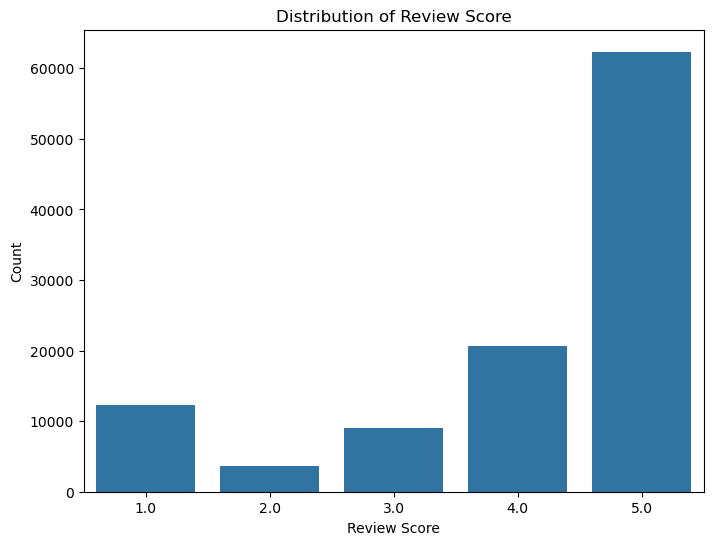

In [39]:
# Get counts of 'Satisfied' and 'Not Satisfied' reviews
review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
# plt.xticks(ticks=range(len(decoded_review_score)), labels=decoded_review_score)
plt.show()

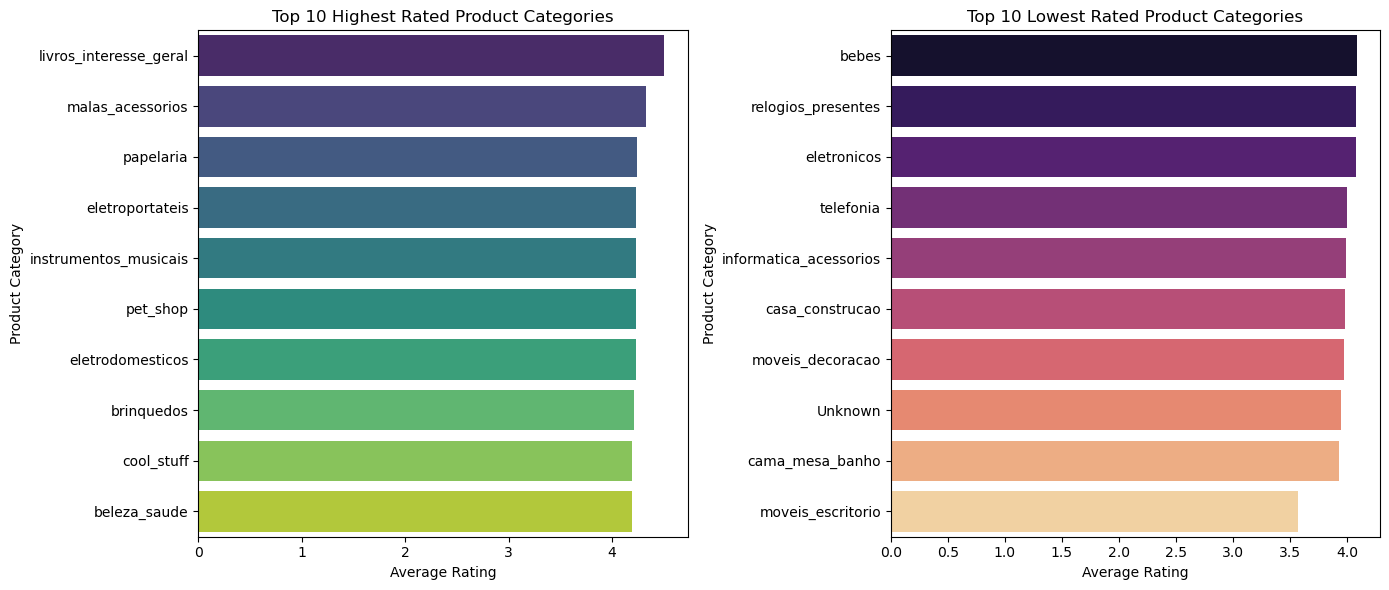

In [40]:
# Calculate the average rating for each product category
category_ratings = ecommerce_no_review_data_df.groupby('product_category_name')['review_score'].mean().reset_index()

# Sort the categories by rating
sorted_category_ratings = category_ratings.sort_values(by='review_score', ascending=False)

# Top 10 highest rated categories
top_categories = sorted_category_ratings.head(10)

# Bottom 10 lowest rated categories
bottom_categories = sorted_category_ratings.tail(10)

# Plotting
plt.figure(figsize=(14, 6))

# Highest Rated Categories
plt.subplot(1, 2, 1)
sns.barplot(x='review_score', y='product_category_name', data=top_categories, palette='viridis')
plt.title('Top 10 Highest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

# Lowest Rated Categories
plt.subplot(1, 2, 2)
sns.barplot(x='review_score', y='product_category_name', data=bottom_categories, palette='magma')
plt.title('Top 10 Lowest Rated Product Categories')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')

plt.tight_layout()
plt.show()

In [41]:
# Convert review_score to binary classification
ecommerce_no_review_data_df['review_score'] = ecommerce_no_review_data_df['review_score'].apply(lambda x: 1 if int(x) >= 4 else 0)

review_score_distribution = ecommerce_no_review_data_df['review_score'].value_counts()

In [42]:
print(review_score_distribution)

1    82996
0    24915
Name: review_score, dtype: int64


In [43]:
# Identify categorical features
categorical_features = [
    'order_status', 'payment_type', 'product_category_name', # 'review_score'
]

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    ecommerce_no_review_data_df[col] = le.fit_transform(ecommerce_no_review_data_df[col])
    label_encoders[col] = le

ecommerce_no_review_data_df.head(5)

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,1.0,...,18.12,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,3.0,...,2.00,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-06 11:07:15,29.99,8.72,2.0,...,18.59,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,1,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,2017-08-21 20:05:16,29.99,7.78,1.0,...,37.77,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,1,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,2017-08-08 18:37:31,29.99,7.78,1.0,...,37.77,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [44]:
ecommerce_no_review_data_df.describe(include='all')

,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,shipping_limit_date,price,freight_value,payment_sequential,...,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,107911.000000,107911,107911,107911,107911,107911,107911,107911.000000,107911.000000,107911.000000,...,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000,107911.000000
unique,NaN,89702,83019,75358,89448,443,85690,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,2017-08-14 20:43:31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,63,63,63,63,618,63,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-10-08 13:46:32,2016-10-11 13:46:32,2016-10-04 00:00:00,2016-09-19 23:11:33,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-08-29 15:00:37,2018-08-29 15:10:26,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-10-25 00:00:00,2020-04-09 22:35:08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.999935,NaN,NaN,NaN,NaN,NaN,NaN,116.620764,19.723151,1.088740,...,166.229737,0.769115,13.535488,48.935317,772.339530,2.179852,2026.525998,30.133647,16.391424,22.836263
std,0.008054,NaN,NaN,NaN,NaN,NaN,NaN,170.705778,15.197108,0.675245,...,218.299661,0.421401,8.640581,9.904817,634.153235,1.698401,3661.277092,15.980789,13.037914,11.356965
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.850000,0.000000,1.000000,...,0.000000,0.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,39.900000,13.070000,1.000000,...,60.780000,1.000000,5.000000,43.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000


In [45]:
# Identify numerical columns excluding encoded categorical columns
encoded_categorical_columns = [f for f in categorical_features]
numerical_columns = ecommerce_no_review_data_df.select_dtypes(include=['number']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in encoded_categorical_columns + ['review_score']]

# Print the identified numerical columns
print("Numerical columns identified:")
print(numerical_columns)

Numerical columns identified:
['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [46]:
# Decode categorical labels for other categorical features
decoded_categories = {}
for col in categorical_features:
    decoded_categories[col] = label_encoders[col].inverse_transform(ecommerce_no_review_data_df[col].unique())

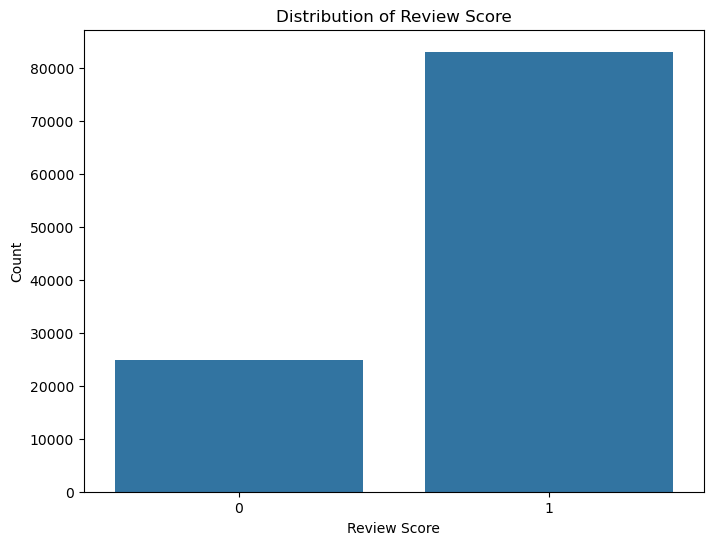

In [47]:
# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=review_score_distribution.index, y=review_score_distribution.values)
plt.title('Distribution of Review Score')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

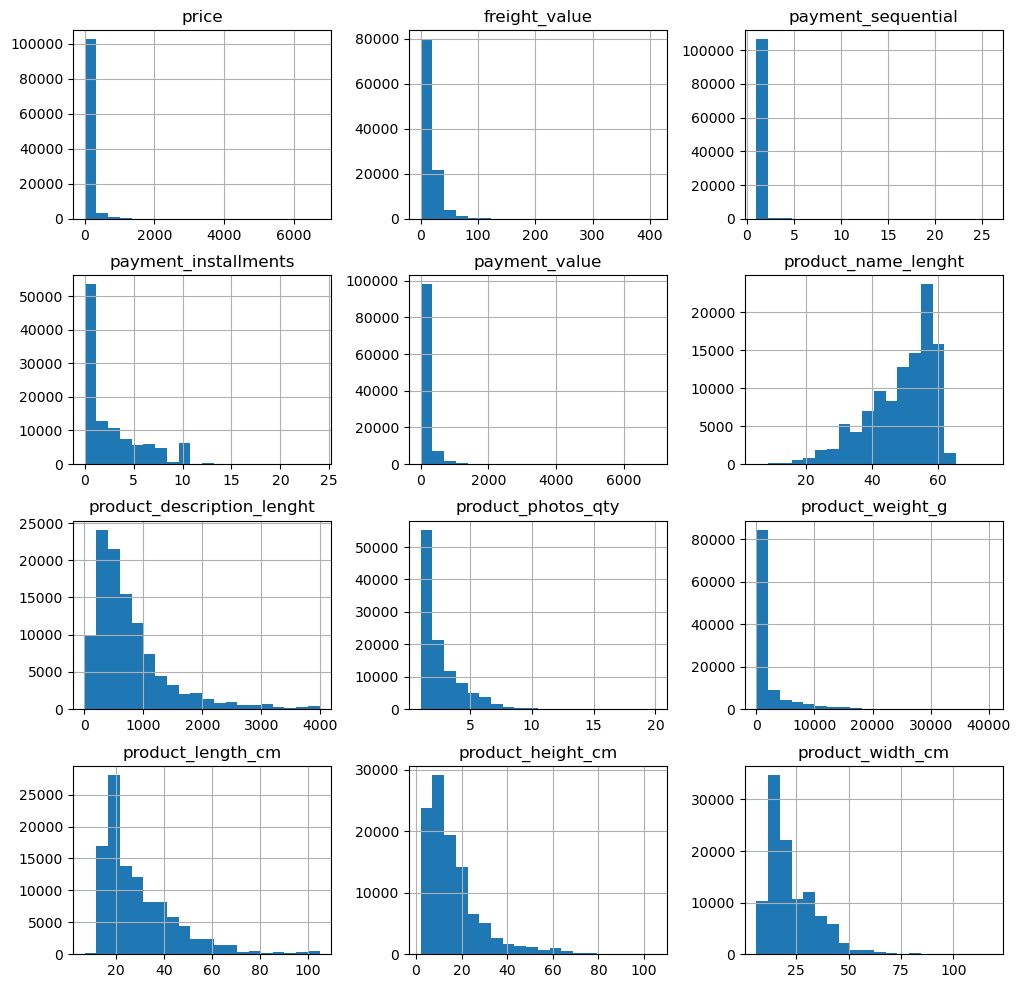

In [48]:
ecommerce_no_review_data_df[numerical_columns].hist(figsize=(12,12),bins=20)
plt.show()

In [49]:
# Calculate skewness
skewness = ecommerce_no_review_data_df[numerical_columns].apply(stats.skew)

# Interpretation
print("Skewness:")
print(skewness)

# Quick analysis
for col, skew_val in skewness.items():
    if abs(skew_val) > 1:
        print(f"{col} is highly skewed (Skewness: {skew_val})")
    elif abs(skew_val) > 0.5:
        print(f"{col} is moderately skewed (Skewness: {skew_val})")
    else:
        print(f"{col} is approximately symmetric (Skewness: {skew_val})")

Skewness:
price                          7.827861
freight_value                  5.548567
payment_sequential            15.588885
payment_installments           1.588896
payment_value                  5.807277
product_name_lenght           -0.941325
product_description_lenght     2.021565
product_photos_qty             1.911917
product_weight_g               3.683609
product_length_cm              1.745334
product_height_cm              2.103535
product_width_cm               1.597617
dtype: float64
price is highly skewed (Skewness: 7.827860529696291)
freight_value is highly skewed (Skewness: 5.548566673858978)
payment_sequential is highly skewed (Skewness: 15.588884532928168)
payment_installments is highly skewed (Skewness: 1.5888960549664655)
payment_value is highly skewed (Skewness: 5.8072771841942945)
product_name_lenght is moderately skewed (Skewness: -0.941325395027531)
product_description_lenght is highly skewed (Skewness: 2.0215654299939523)
product_photos_qty is highly skewed 

The skewness values for the dataset's numerical features indicate the extent of asymmetry in their distributions. Notably, several features, including price, freight value, payment sequential, payment installments, and payment value, exhibit highly skewed distributions, suggesting a pronounced imbalance towards one tail of the distribution. Similarly, product description length, product photos quantity, product weight, length, height, and width show noticeable skewness, although to a lesser degree. Intriguingly, product name length displays moderate negative skewness, indicating a slight bias towards higher values, albeit in the opposite direction compared to other features. These observations underscore the non-normal distribution of many numerical features in the dataset, implying the potential need for transformations or specialized modeling techniques to address these skewness issues effectively.

There is a Severe Imbalance Between the Reviews

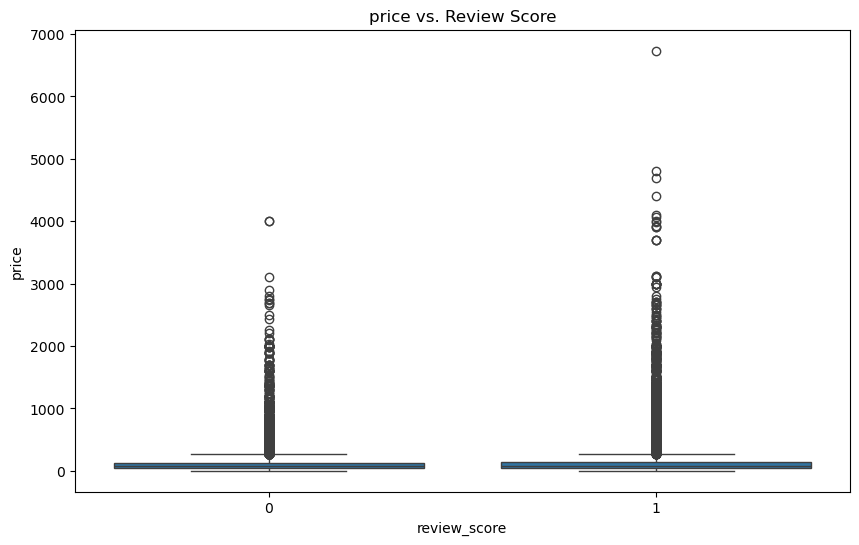

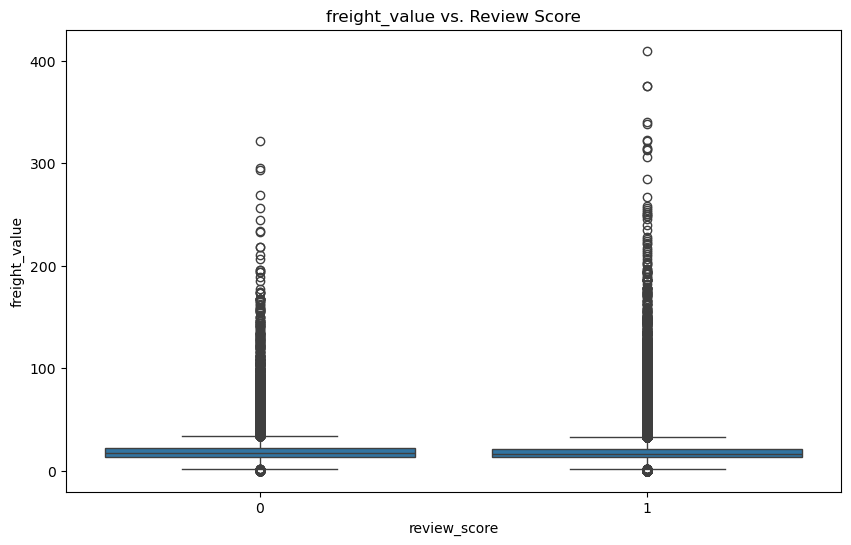

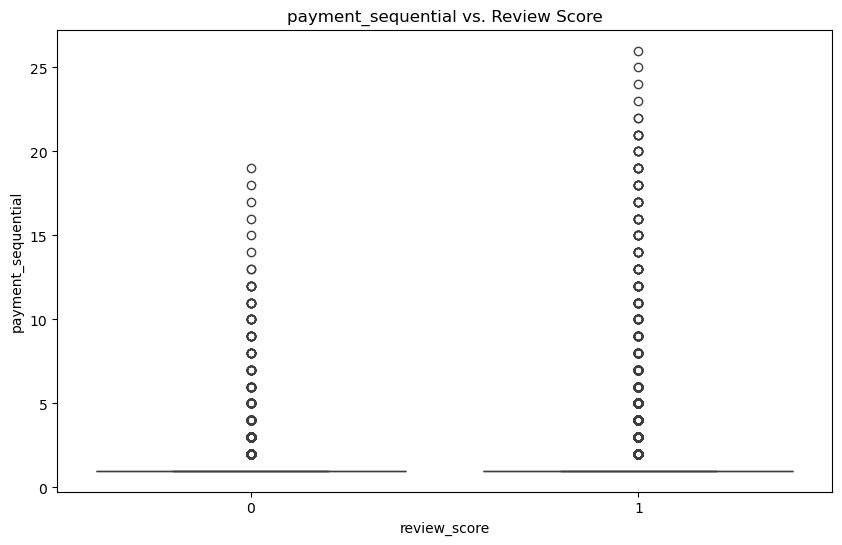

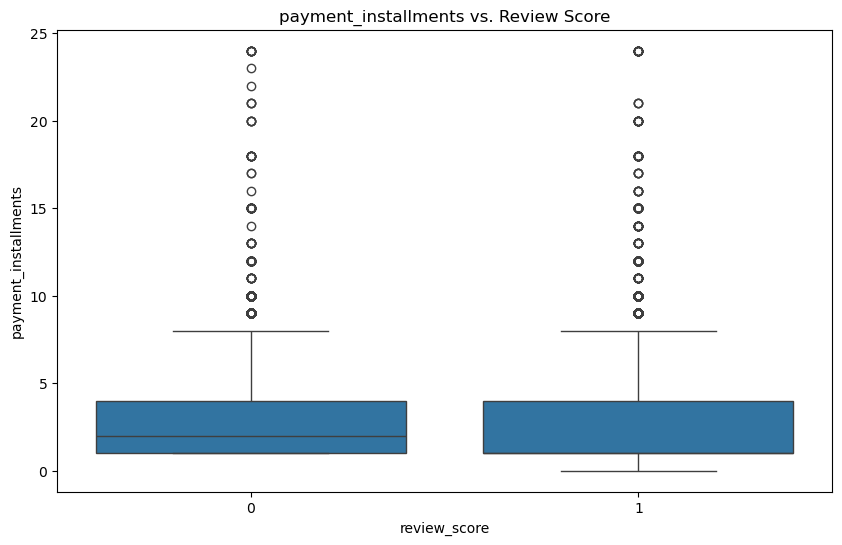

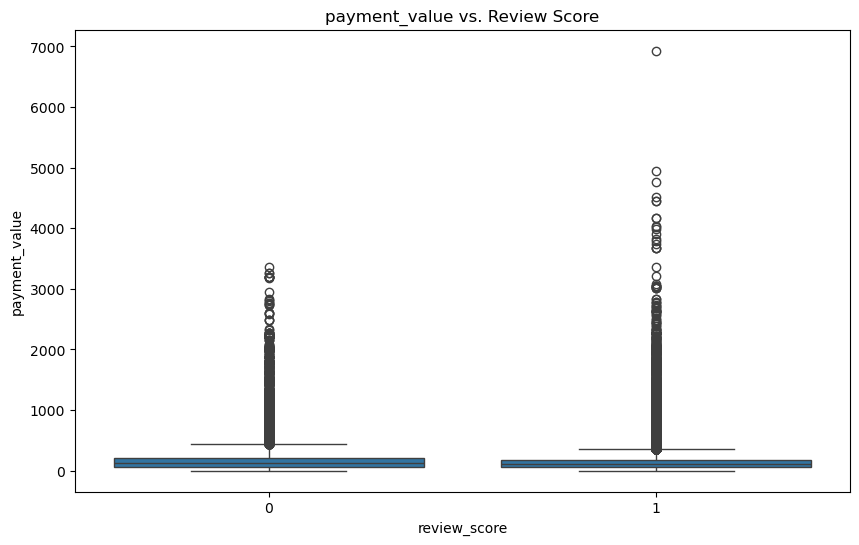

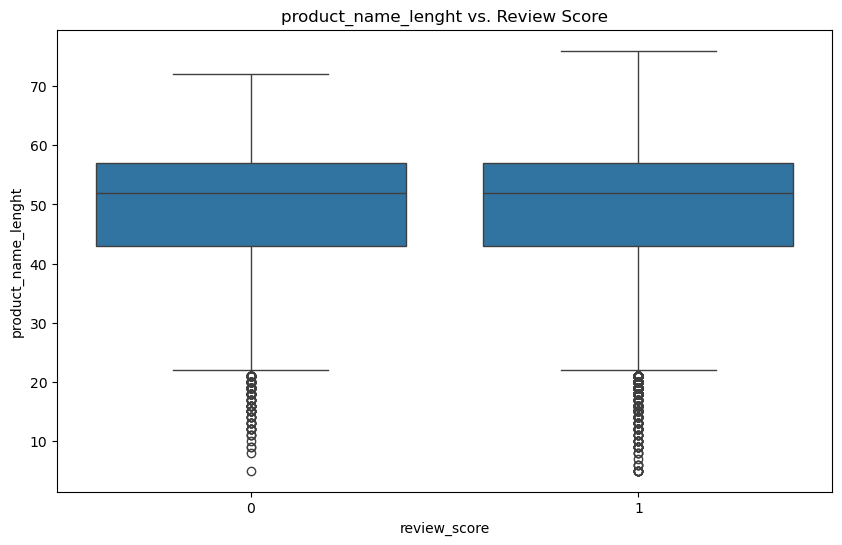

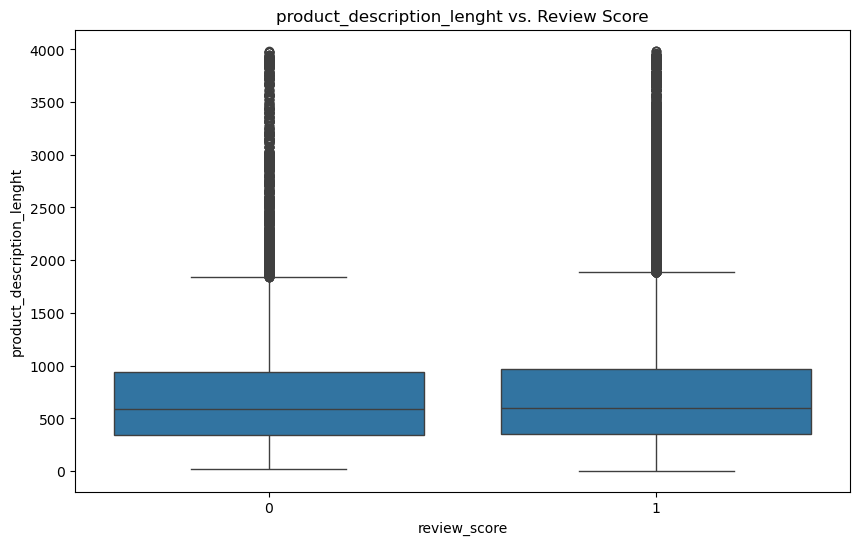

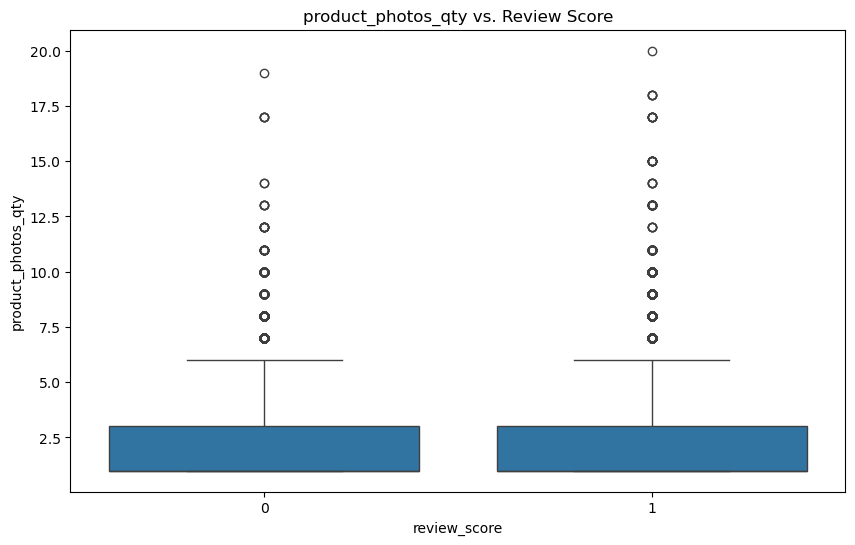

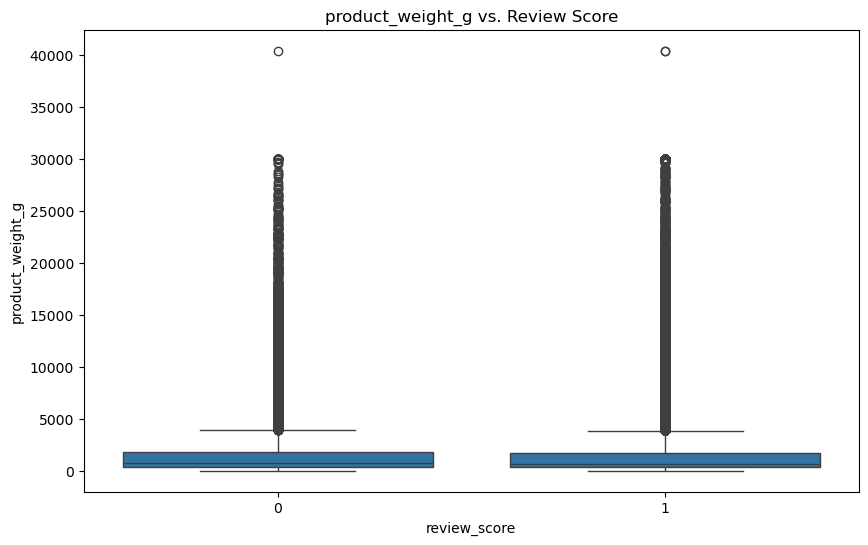

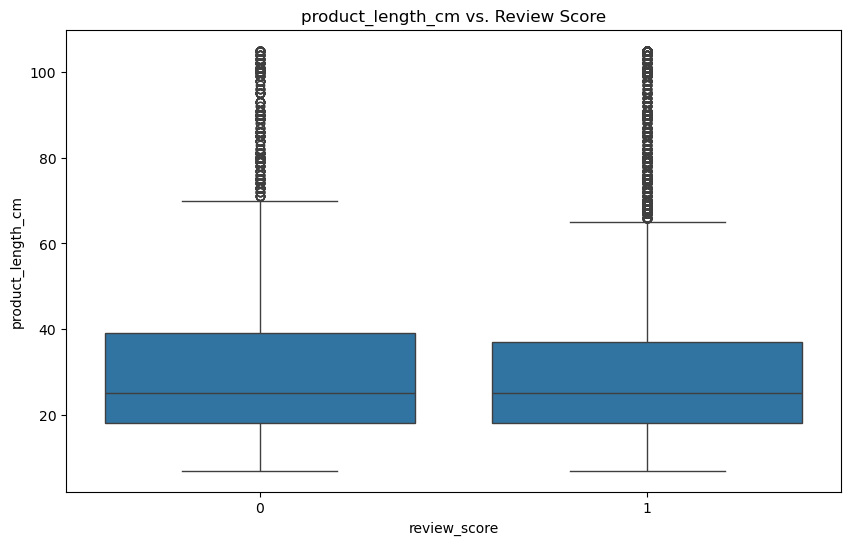

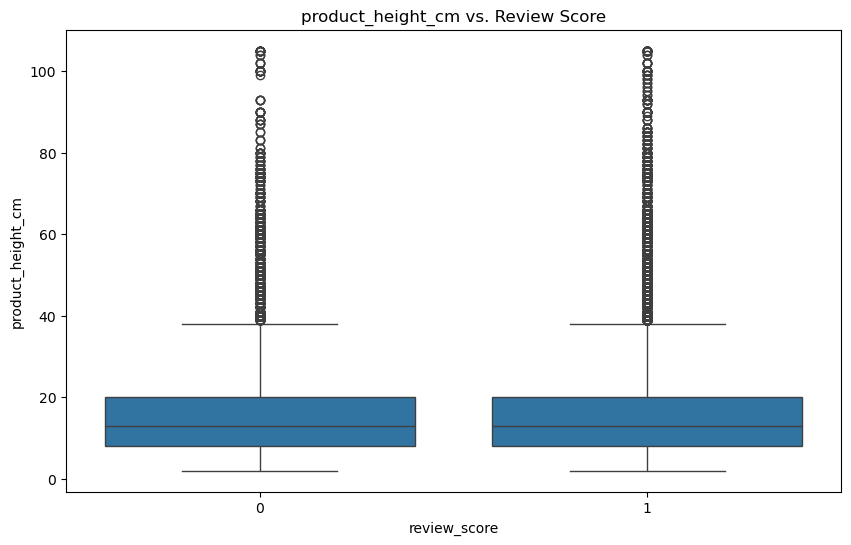

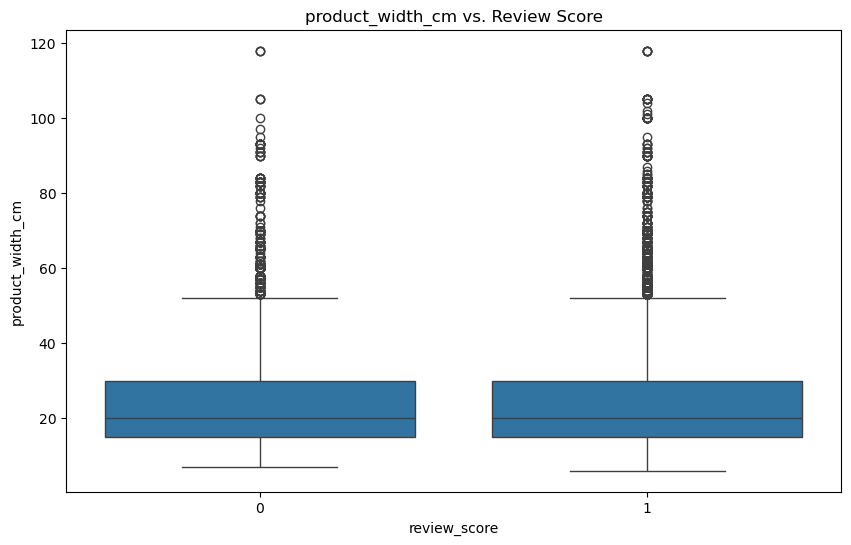

In [50]:
# Box plot for numerical features vs. review score
for feature in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='review_score', y=feature, data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    plt.show()

/opt/conda/lib/python3.8/site-packages/scipy/stats/_stats_py.py:5278: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


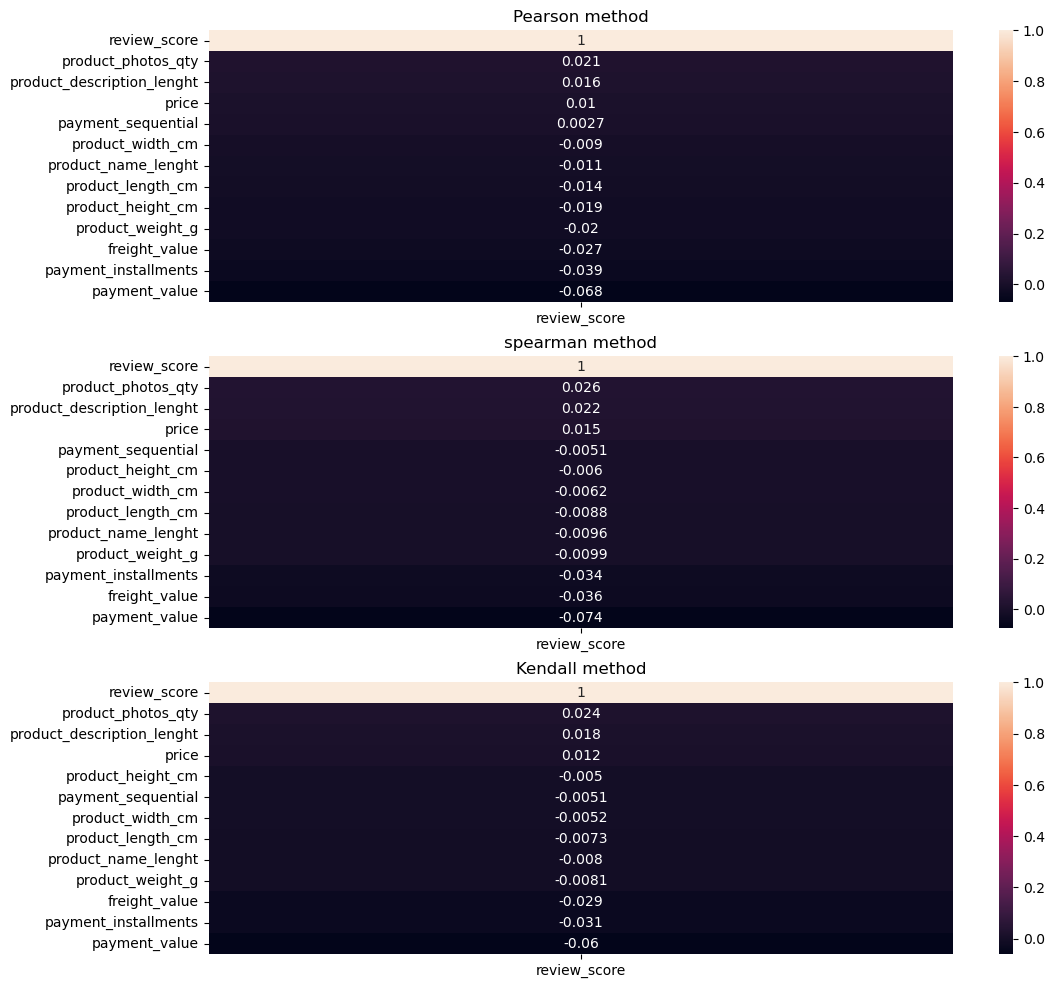

In [51]:
fig, ax = plt.subplots(3,1, figsize=(12, 12))
## Correlation coefficient using different methods
corr1 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('pearson')[['review_score']].sort_values(by='review_score', ascending=False)
corr2 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('spearman')[['review_score']].sort_values(by='review_score', ascending=False)
corr3 = ecommerce_no_review_data_df[numerical_columns + ['review_score']].corr('kendall')[['review_score']].sort_values(by='review_score', ascending=False)

#setting titles for each plot
ax[0].set_title('Pearson method')
ax[1].set_title('spearman method')
ax[2].set_title('Kendall method')
## Generating heatmaps of each methods
sns.heatmap(corr1, ax=ax[0], annot=True)
sns.heatmap(corr2, ax=ax[1], annot=True)
sns.heatmap(corr3, ax=ax[2], annot=True)

plt.show()

It becomes apparent that non of the numerical feautres have a strong enough correlation to impact review_score

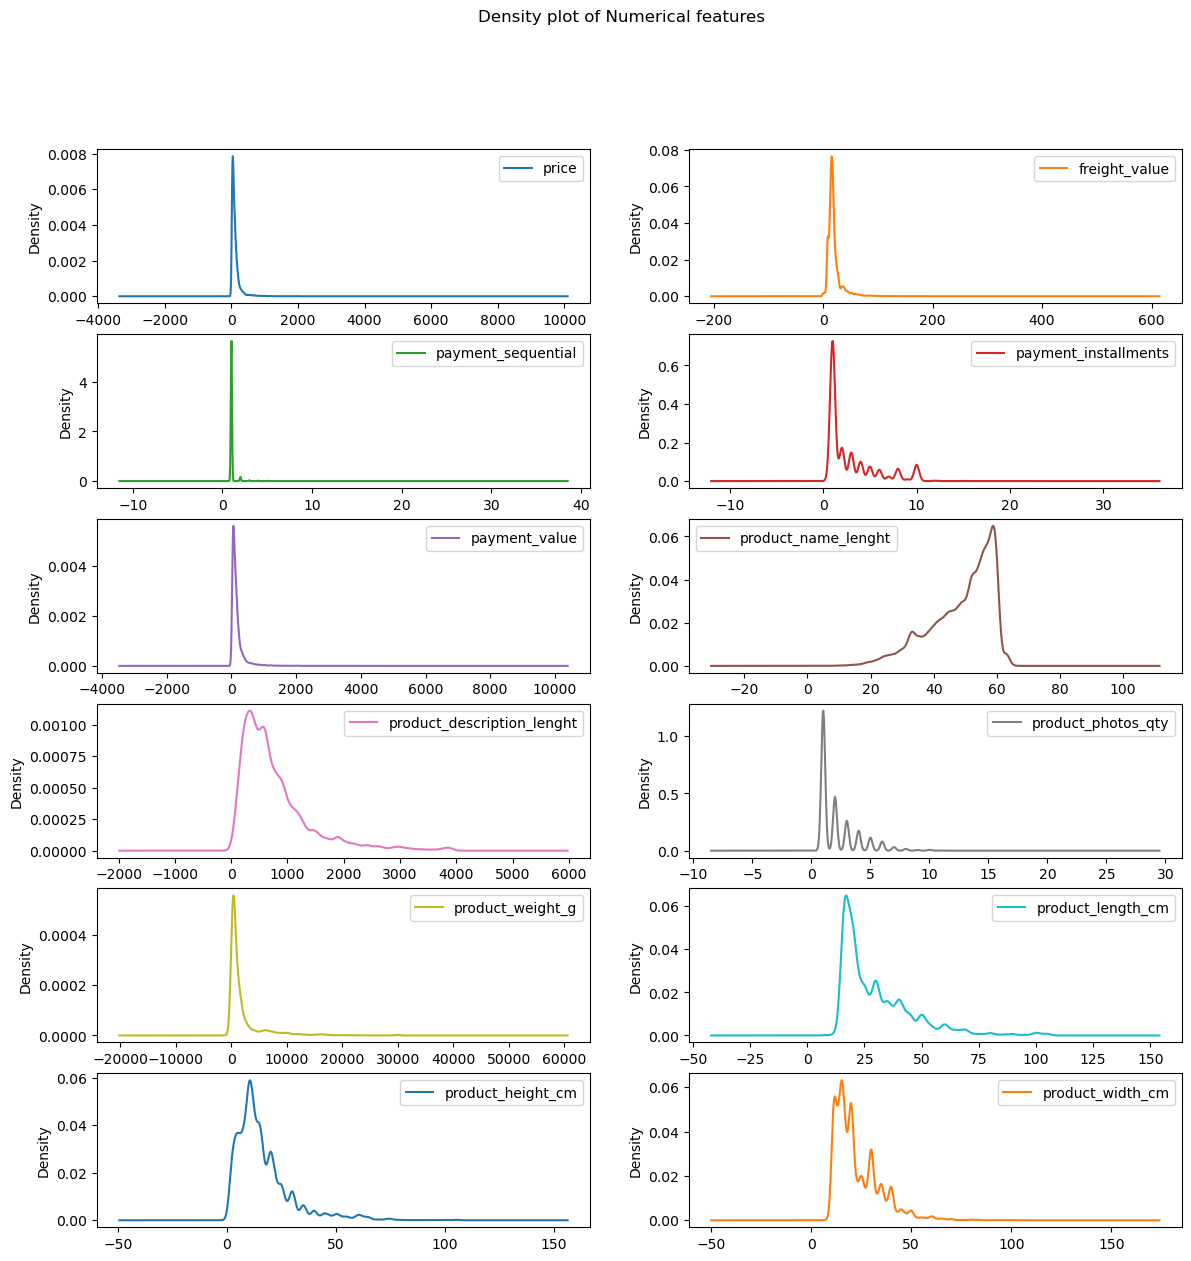

In [52]:
ecommerce_no_review_data_df[numerical_columns].plot(kind='density',figsize=(14,14),subplots=True,layout=(6,2),title="Density plot of Numerical features",sharex=False)
plt.show()

There is an Imbalance Not only in the Review Distribution but in the Numerical Feature Distributions as well

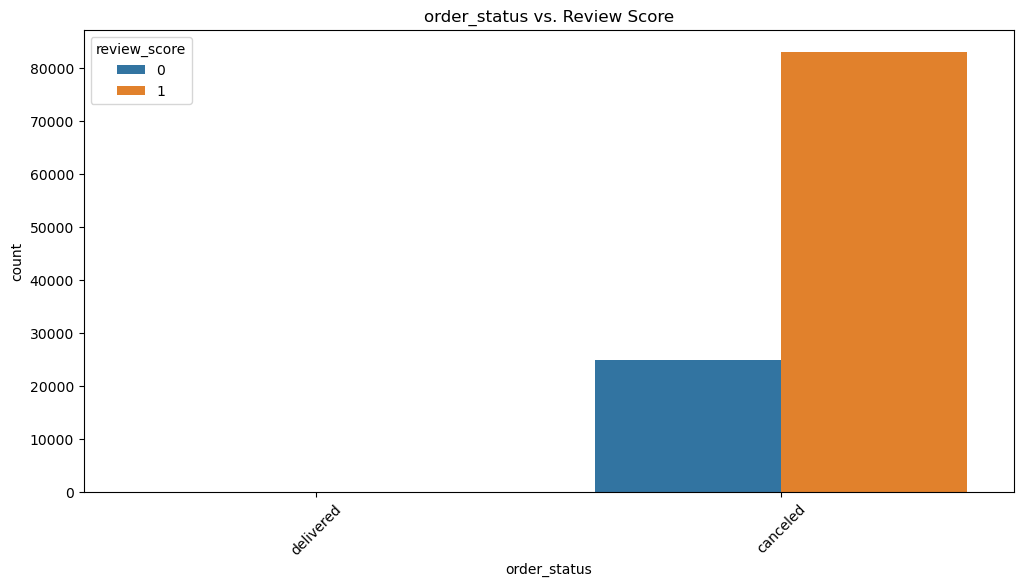

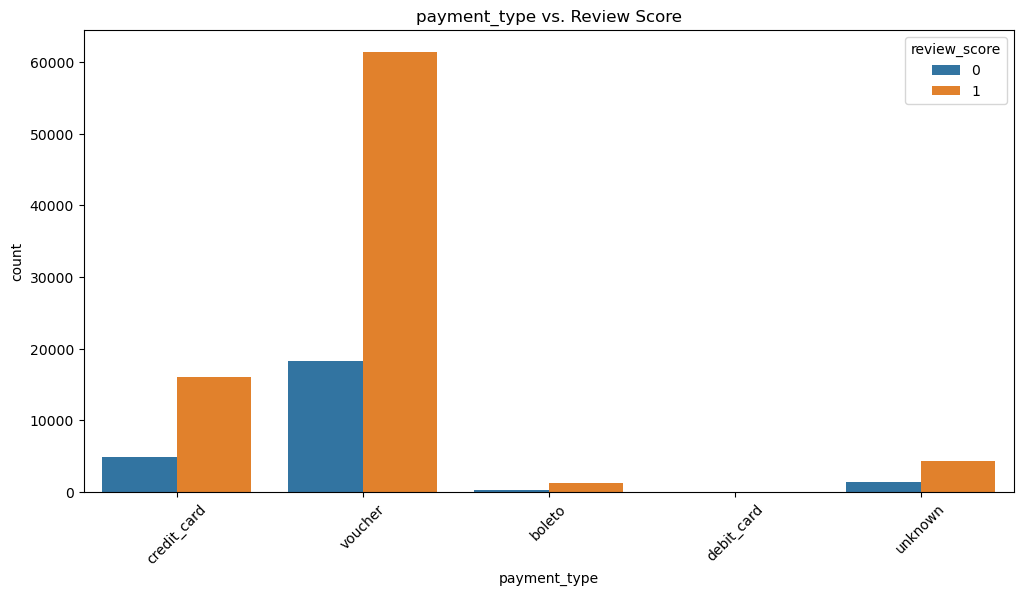

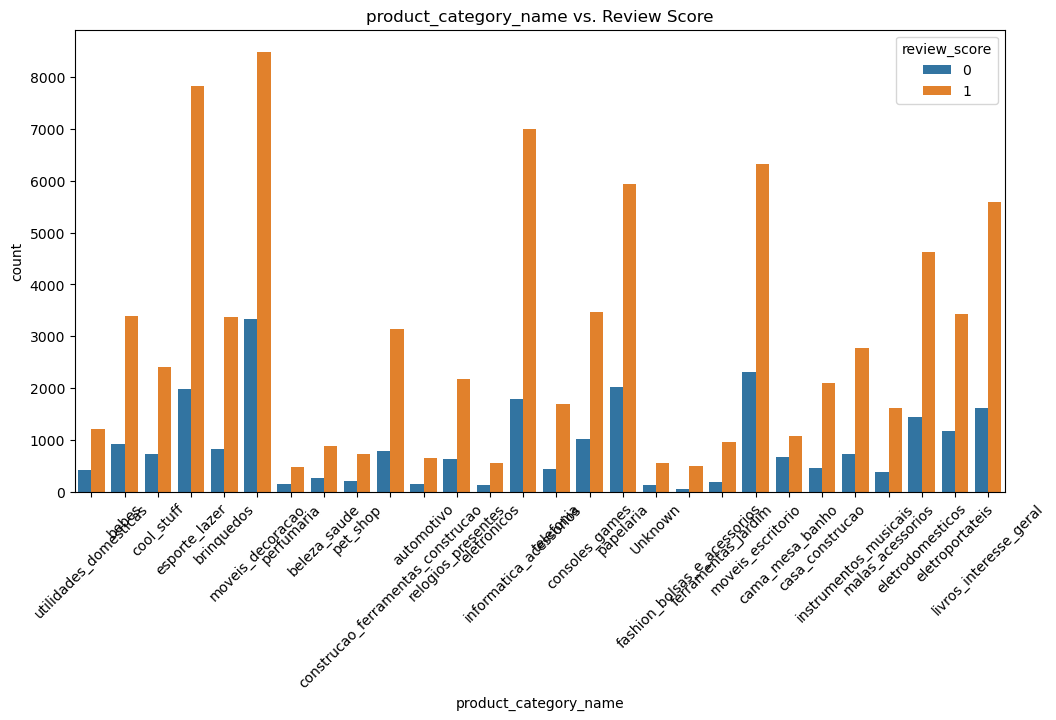

In [53]:
# Bar plot for categorical features vs. review score
for feature in categorical_features:
    if feature == 'review_score':
        continue
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='review_score', data=ecommerce_no_review_data_df)
    plt.title(f'{feature} vs. Review Score')
    # Decode x-axis labels for other categorical features
    plt.xticks(ticks=range(len(decoded_categories[feature])), labels=decoded_categories[feature], rotation=45)
    plt.show()

## Feature Engineering ##

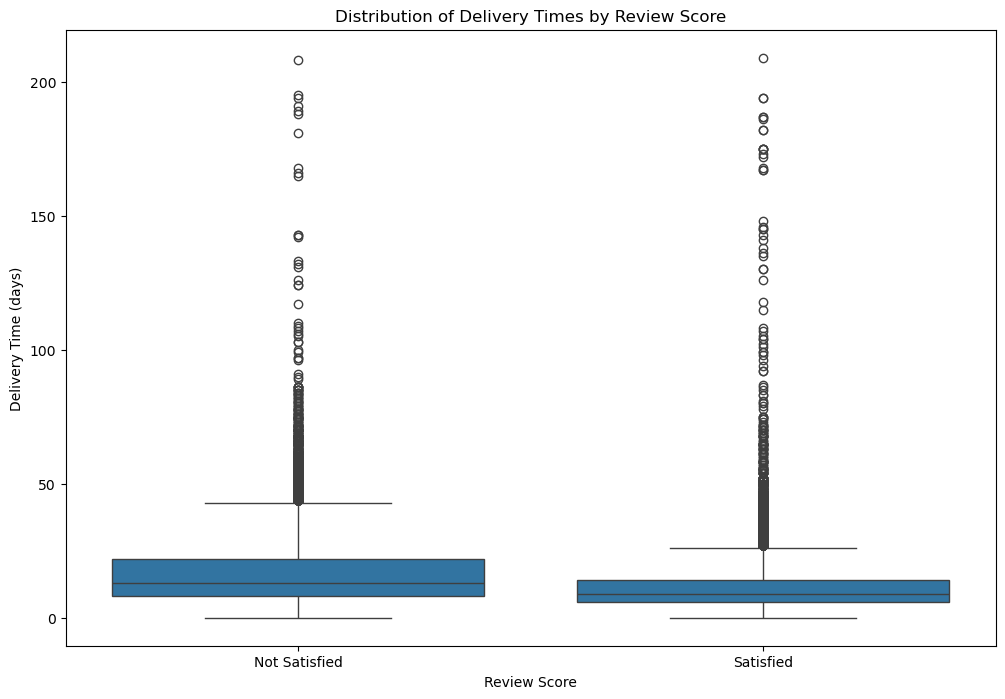

In [54]:
# Calculate the delivery time in days
ecommerce_no_review_data_df['delivery_time_days'] = (ecommerce_no_review_data_df['order_delivered_customer_date'] - ecommerce_no_review_data_df['order_purchase_timestamp']).dt.days

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='review_score', y='delivery_time_days', data=ecommerce_no_review_data_df)
plt.title('Distribution of Delivery Times by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.xticks(ticks=[0, 1], labels=['Not Satisfied', 'Satisfied'])
plt.show()

The box plots shows that there is a negative correlation between delivery time and review score. It means customers who get an order with longer delivery times tend to give bad reviews.

In [55]:
# Create is_late feature
ecommerce_no_review_data_df['is_late'] = (ecommerce_no_review_data_df['order_delivered_customer_date'] > ecommerce_no_review_data_df['order_estimated_delivery_date']).astype(int)

# Calculate seller response time in hours
ecommerce_no_review_data_df['seller_response_time'] = (ecommerce_no_review_data_df['order_approved_at'] - ecommerce_no_review_data_df['order_purchase_timestamp']).dt.total_seconds() / 3600

print(ecommerce_no_review_data_df[['is_late', 'seller_response_time']].head())

   is_late  seller_response_time
0        0              0.178333
1        0              0.178333
2        0              0.178333
3        0              1.595833
4        0              0.307778


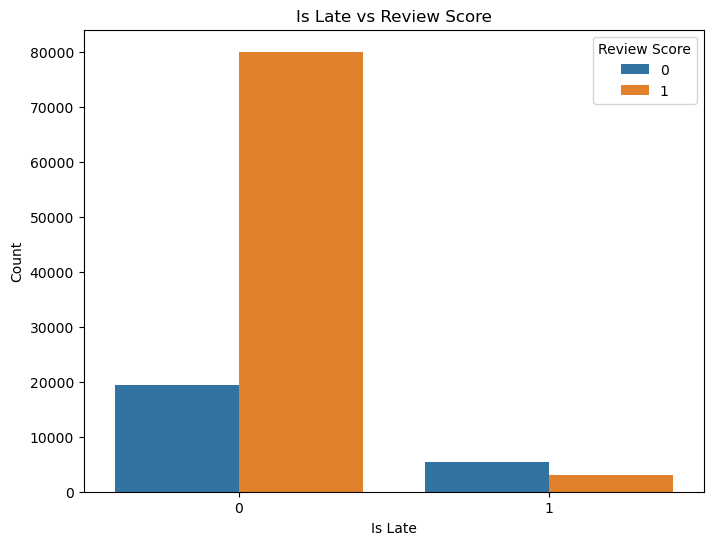

In [56]:
# Distribution of is_late
plt.figure(figsize=(8, 6))
sns.countplot(x='is_late', hue='review_score', data=ecommerce_no_review_data_df)
plt.title('Is Late vs Review Score')
plt.xlabel('Is Late')
plt.ylabel('Count')
plt.legend(title='Review Score')
plt.show()

Even with the Imbalance in 'Satisfied' (1) and 'Not Satsified' (0), If a Delivery is Late it is More Likely to have a negative review

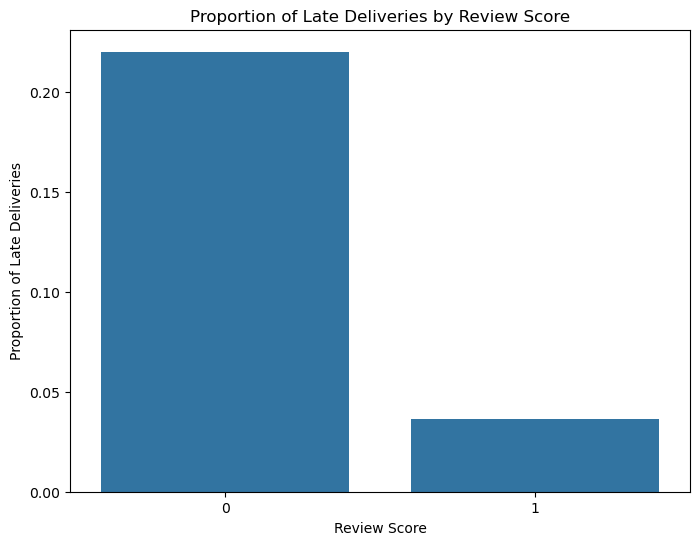

In [57]:
# Proportion of late deliveries by review score
late_review_prop = ecommerce_no_review_data_df.groupby('review_score')['is_late'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='review_score', y='is_late', data=late_review_prop)
plt.title('Proportion of Late Deliveries by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Proportion of Late Deliveries')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


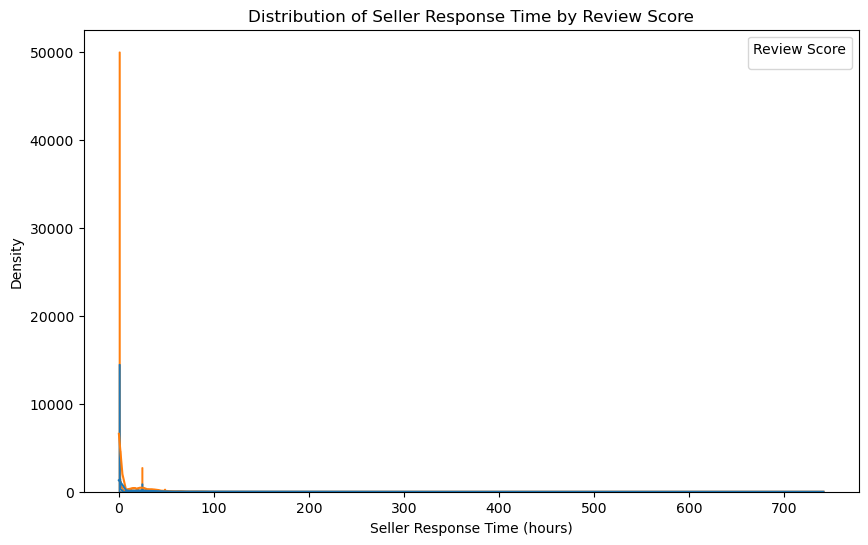

In [58]:
# Distribution of seller_response_time
plt.figure(figsize=(10, 6))
sns.histplot(ecommerce_no_review_data_df, x='seller_response_time', hue='review_score', kde=True, element='step')
plt.title('Distribution of Seller Response Time by Review Score')
plt.xlabel('Seller Response Time (hours)')
plt.ylabel('Density')
plt.legend(title='Review Score')
plt.show()

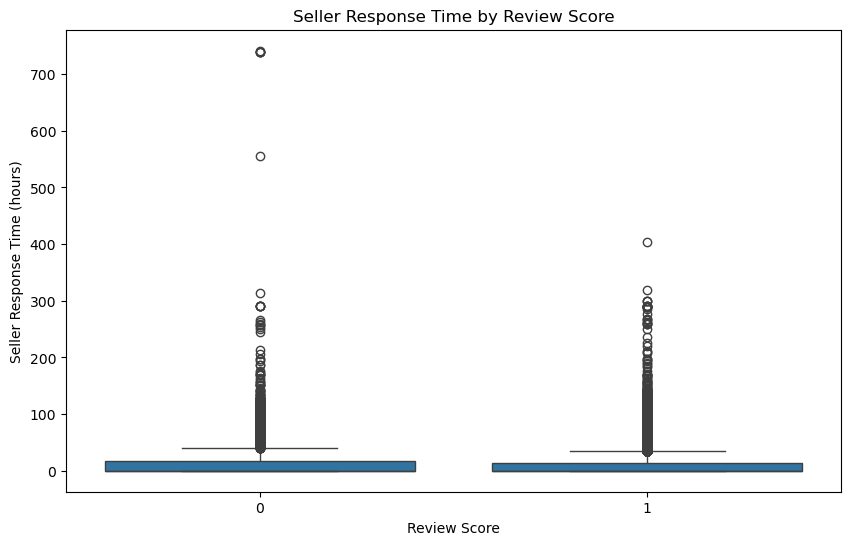

In [59]:
# Boxplot of seller_response_time by review_score
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='seller_response_time', data=ecommerce_no_review_data_df)
plt.title('Seller Response Time by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Seller Response Time (hours)')
plt.show()

In [60]:
# Drop Datetime Stamps
ecommerce_no_date_data_df = ecommerce_no_review_data_df.drop(columns=[col for col in datetime_columns if 'review' not in col])

ecommerce_no_date_data_df.head(5)

,order_status,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_time_days,is_late,seller_response_time
0,1,29.99,8.72,1.0,1,1.0,18.12,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
1,1,29.99,8.72,3.0,4,1.0,2.00,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
2,1,29.99,8.72,2.0,4,1.0,18.59,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0,8,0,0.178333
3,1,29.99,7.78,1.0,1,3.0,37.77,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0,2,0,1.595833
4,1,29.99,7.78,1.0,1,1.0,37.77,1,27,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,0,0.307778


#### Drop Unrelated Features ####

In [61]:
features_to_drop = ['order_status','payment_type', 'payment_sequential', 'payment_installments', 'product_name_lenght', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_response_time']
ecommerce_feature_eng_df = ecommerce_no_date_data_df.drop(columns=features_to_drop)

ecommerce_feature_eng_df.head(5)

,price,freight_value,payment_value,review_score,product_category_name,product_description_lenght,product_photos_qty,delivery_time_days,is_late
0,29.99,8.72,18.12,1,27,268.0,4.0,8,0
1,29.99,8.72,2.00,1,27,268.0,4.0,8,0
2,29.99,8.72,18.59,1,27,268.0,4.0,8,0
3,29.99,7.78,37.77,1,27,268.0,4.0,2,0
4,29.99,7.78,37.77,1,27,268.0,4.0,5,0


In [62]:
numerical_feats = [col for col in ecommerce_feature_eng_df.columns if col not in categorical_features + ['review_score', 'is_late']]

numerical_feats

['price',
 'freight_value',
 'payment_value',
 'product_description_lenght',
 'product_photos_qty',
 'delivery_time_days']

In [63]:
## Feature Store ##
### Ingest Data into Feature Store ###
review_feature_group_name = 'review-feature-group' + strftime("%d-%H-%M-%S", gmtime())

current_time_sec = int(round(time()))

review_feature_group = FeatureGroup(name=review_feature_group_name, sagemaker_session=feature_store_session)

In [64]:
# record identifier and event time feature names
# record_identifier_feature_name = "review"
event_time_feature_name = "EventTime"

# append EventTime feature
ecommerce_feature_eng_df[event_time_feature_name] = pd.Series(
    [current_time_sec] * len(ecommerce_feature_eng_df), dtype="float64"
)

# load feature definitions to the feature group. SageMaker FeatureStore Python SDK will auto-detect the data schema based on input data.
review_feature_group.load_feature_definitions(data_frame=ecommerce_feature_eng_df)

[FeatureDefinition(feature_name='price', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='freight_value', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='payment_value', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='review_score', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='product_category_name', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>, collection_type=None),
 FeatureDefinition(feature_name='product_description_lenght', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='product_photos_qty', feature_type=<FeatureTypeEnum.FRACTIONAL: 'Fractional'>, collection_type=None),
 FeatureDefinition(feature_name='delivery_time_days', feature_type=<FeatureTypeEnum.INTE

## Perform Data Split ##

In [65]:
# Define features (X) and target variable (y)
X = ecommerce_feature_eng_df.drop(columns=['review_score'])
y = ecommerce_feature_eng_df['review_score']

# Split the data into training (40%), test (10%), validation (10%), and production (40%) datasets
X_train_val, X_production, y_train_val, y_production = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Production set shape:", X_production.shape, y_production.shape)

Train set shape: (48559, 9) (48559,)
Test set shape: (8093, 9) (8093,)
Validation set shape: (8094, 9) (8094,)
Production set shape: (43165, 9) (43165,)


In [66]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train[numerical_feats] = scaler.fit_transform(X_train[numerical_feats])

# Transform the validation and test data using the same scaler
X_val[numerical_feats] = scaler.transform(X_val[numerical_feats])
X_test[numerical_feats] = scaler.transform(X_test[numerical_feats])
X_production[numerical_feats] = scaler.transform(X_production[numerical_feats])

# Check the result
print(X_train.head())

           price  freight_value  payment_value  product_category_name  \
13944  -0.329618       0.957642      -0.327521                      2   
47023  -0.556802      -0.787210      -0.622427                     13   
80605  -0.435027      -0.541717      -0.689879                      9   
22844  -0.329618      -0.276425      -0.071501                     13   
108757  0.135699      -0.253988      -0.050234                      3   

        product_description_lenght  product_photos_qty  delivery_time_days  \
13944                     0.489820           -0.697678            0.631746   
47023                    -0.060993           -0.697678           -0.740169   
80605                    -0.588065           -0.108517            0.420682   
22844                     0.605364           -0.108517           -0.740169   
108757                   -0.252512           -0.108517           -0.740169   

        is_late     EventTime  
13944         0  1.717449e+09  
47023         0  1.717449e+0

## Benchmark XGBoost Model ##

In [67]:
# Merge features and target variable for training and validation sets
train_data = pd.concat([y_train, X_train], axis=1)
val_data = pd.concat([y_val, X_val], axis=1)

In [68]:
# Upload Split Data into S3
train_file = "train_data.csv"
train_data.to_csv(train_file, index=False, header=False)
sess.upload_data(train_file, key_prefix="{}/data/train".format(prefix))

validation_file = "validation_data.csv"
val_data.to_csv(validation_file, index=False, header=False)
sess.upload_data(validation_file, key_prefix="{}/data/validation".format(prefix))

batch_file = "batch_data.csv"
X_test.to_csv(batch_file, index=False, header=False)
sess.upload_data(batch_file, key_prefix="{}/data/batch".format(prefix))

prod_file = "prod_data.csv"
X_production.to_csv(prod_file, index=False, header=False)
sess.upload_data(prod_file, key_prefix="{}/data/prod".format(prefix))

's3://sagemaker-us-east-1-757088774357/olist_review_score/data/prod/prod_data.csv'

In [69]:
job_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: ", job_name)
endpoint_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint name: ", endpoint_name)
output_location = "s3://{}/{}/output/{}".format(bucket, prefix, job_name)
print("S3 location for model", output_location)
image = sagemaker.image_uris.retrieve(
    framework="xgboost", region=boto3.Session().region_name, version="1.7-1"
)

eval_metrics = 'auc,aucpr,f1,precision,recall'

sm_estimator = sagemaker.estimator.Estimator(
    image,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sess,
)

sm_estimator.set_hyperparameters(
    objective= 'binary:logistic',  # Binary classification
    max_depth= 5,  # Maximum depth of each tree
    eta= 0.2,  # Learning rate
    gamma= 4,  # Minimum loss reduction required to make a further partition on a leaf node
    subsample= 0.8,  # Subsample ratio of the training instances
    colsample_bytree= 0.8,  # Subsample ratio of columns when constructing each tree
    eval_metric= eval_metrics,  # Evaluation metric
    alpha= 0.1,  # L1 regularization term
    num_round=100
)

train_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/train".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/data/validation".format(bucket, prefix),
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

# Start training by calling the fit method in the estimator
sm_estimator.fit(inputs=data_channels, job_name=job_name, logs=True)

INFO:sagemaker:Creating training-job with name: benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06


Model name:  benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06
Endpoint name:  benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06
S3 location for model s3://sagemaker-us-east-1-757088774357/olist_review_score/output/benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06
2024-06-03 21:09:07 Starting - Starting the training job...
2024-06-03 21:09:24 Starting - Preparing the instances for training...
2024-06-03 21:09:48 Downloading - Downloading input data...
2024-06-03 21:10:19 Downloading - Downloading the training image...
2024-06-03 21:10:54 Training - Training image download completed. Training in progress..[2024-06-03 21:11:02.441 ip-10-0-246-203.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-03 21:11:02.473 ip-10-0-246-203.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-03:21:11:02:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-03:21:11:02:INFO] Failed to pa

### Benchmark Results on Batch Data ###

In [70]:
# Create the transformer object
transformer = sm_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.xlarge",
)

# Specify the S3 URI of the test data
test_data_s3_uri = "s3://{}/{}/data/batch/{}".format(bucket, prefix, batch_file)

transformer.transform(
    test_data_s3_uri,
    split_type="Line",
    content_type="text/csv",
)

# Wait for the job to complete
transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-06-03-21-11-49-085
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-06-03-21-11-49-784


..................................[2024-06-03:21:17:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-03:21:17:25:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-03:21:17:25:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-06-03 21:17:25 +0000] [19] [INFO] Starting g

In [71]:
# Initialize Boto3 S3 client
s3_client = boto3.client('s3')

def get_csv_output_from_s3(s3uri, batch_file):
    file_name = "{}.out".format(batch_file)
    match = re.match("s3://([^/]+)/(.*)", "{}/{}".format(s3uri, file_name))
    output_bucket, output_prefix = match.group(1), match.group(2)
    print(output_bucket + output_prefix)
    s3_client.download_file(output_bucket, output_prefix, file_name)
    return pd.read_csv(file_name, sep=",", header=None)

In [72]:
batch_out_df = get_csv_output_from_s3(transformer.output_path, batch_file)
batch_out_df.head(5)

sagemaker-us-east-1-757088774357sagemaker-xgboost-2024-06-03-21-11-49-784/batch_data.csv.out


,0
0,0.863576
1,0.835123
2,0.897757
3,0.879201
4,0.654190


### Batch BenchModel Metrics  ###

In [73]:
def convert_probabilities_to_binary(probabilities, threshold=0.5):
    # Convert probabilities to binary predictions
    binary_predictions = (probabilities >= threshold).astype(int)
    return binary_predictions

def calculate_metrics(y_true, y_prob):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_prob)
    precision = precision_score(y_true, y_prob)
    recall = recall_score(y_true, y_prob)
    f1 = f1_score(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    
    return accuracy, precision, recall, f1, roc_auc

def print_metrics(accuracy, precision, recall, f1, roc_auc):
    metrics_string = f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}"
    print(metrics_string)


In [74]:
y_prob = convert_probabilities_to_binary(batch_out_df[0])

accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch = calculate_metrics(y_test, y_prob)

print_metrics(accuracy_batch, precision_batch, recall_batch, f1_batch, roc_auc_batch)

Accuracy: 0.8049, Precision: 0.8137, Recall: 0.9682, F1 Score: 0.8842, ROC AUC: 0.6137


The accuracy metric, which measures the overall correctness of the model's predictions, may appear deceptively high in the presence of class imbalance. In scenarios where the majority class dominates, a model could achieve high accuracy by simply predicting the majority class for every instance, without effectively capturing the nuances of the minority class.

Precision, recall, and F1 score are metrics that focus specifically on the performance of the minority class, making them more informative in imbalanced datasets. Precision reflects the proportion of true positive predictions among all positive predictions made by the model. In this case, the precision of 0.8141 suggests that the model correctly identifies a substantial portion of positive instances but may also produce false positives.

Recall, on the other hand, measures the proportion of true positive predictions among all actual positive instances in the dataset. The high recall value of 0.9611 indicates that the model effectively captures the majority of positive instances present in the data.

The F1 score, which represents the harmonic mean of precision and recall, provides a balanced assessment of the model's ability to correctly identify positive instances while minimizing false positives. The F1 score of 0.8815 suggests that the model achieves a good balance between precision and recall, considering the imbalanced nature of the dataset.

ROC AUC (Receiver Operating Characteristic Area Under the Curve) measures the model's ability to distinguish between the positive and negative classes across various threshold values. However, in imbalanced datasets, ROC AUC may not fully capture the performance of the minority class, as it can be dominated by the majority class. Therefore, the ROC AUC value of 0.6391 should be interpreted with caution, considering the class imbalance.

## Model Optimization ##

## Upload model to Sagemaker Model Registry

In [75]:
job_name

'benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06'

In [76]:
sagemaker = boto3.client("sagemaker")

model_name = job_name
info = sagemaker.describe_training_job(TrainingJobName=model_name)
model_data = info["ModelArtifacts"]["S3ModelArtifacts"]

primary_container = {"Image": image, "ModelDataUrl": model_data}

# Save our model to the Sagemaker Model Registry
create_model_response = sagemaker.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=primary_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:757088774357:model/benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06


In [77]:
# Describe the model to get its details
model_description = sm.describe_model(ModelName=model_name)

# Extract the S3 path of the model artifacts
model_artifacts_s3_path = model_description['PrimaryContainer']['ModelDataUrl']

print(f"Model artifacts are stored at: {model_artifacts_s3_path}")

Model artifacts are stored at: s3://sagemaker-us-east-1-757088774357/olist_review_score/output/benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06/benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06/output/model.tar.gz


## Deploy pre-trained model with data capture enabled

In [78]:
from sagemaker.model import Model
from sagemaker.model_monitor import DataCaptureConfig
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session, Session, image_uris

##S3 prefixes
data_capture_prefix = f"{prefix}/datacapture"
s3_capture_upload_path = f"s3://{bucket}/{data_capture_prefix}"

ground_truth_upload_path = (
    f"s3://{bucket}/{prefix}/ground_truth_data/{datetime.now():%Y-%m-%d-%H-%M-%S}"
)

reports_prefix = f"{prefix}/reports"
s3_report_path = f"s3://{bucket}/{reports_prefix}"

##Get the model monitor image
monitor_image_uri = image_uris.retrieve(framework="model-monitor", region=region)

print("Image URI:", monitor_image_uri)
print(f"Capture path: {s3_capture_upload_path}")
print(f"Ground truth path: {ground_truth_upload_path}")
print(f"Report path: {s3_report_path}")

endpoint_name = 'benchmark-xgboost-review-score-prediction-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Endpoint name: ", endpoint_name)
print ("Model name: ", model_name)



INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Image URI: 156813124566.dkr.ecr.us-east-1.amazonaws.com/sagemaker-model-monitor-analyzer
Capture path: s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture
Ground truth path: s3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-03-21-18-25
Report path: s3://sagemaker-us-east-1-757088774357/olist_review_score/reports
Endpoint name:  benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25
Model name:  benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06


In [79]:
model = Model(
    role=role,
    name=model_name,
    image_uri=image,
    model_data=model_artifacts_s3_path,
    sagemaker_session=sess,
)

In [80]:
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
)
print(f"Deploying model {model_name} to endpoint {endpoint_name}")
model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    endpoint_name=endpoint_name,
    data_capture_config=data_capture_config,
)

Deploying model benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06 to endpoint benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25


INFO:sagemaker:Creating model with name: benchmark-xgboost-review-score-prediction-2024-06-03-21-09-06
INFO:sagemaker:Creating endpoint-config with name benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25
INFO:sagemaker:Creating endpoint with name benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25


--------!

In [88]:
#Create the SageMaker Predictor object from the endpoint to be used for invoking the model
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.s3 import S3Downloader, S3Uploader

predictor = Predictor(
    endpoint_name=endpoint_name, sagemaker_session=sess, serializer=CSVSerializer()
)

## Generate a baseline for model quality performance 

In [84]:
churn_cutoff = 0.8
validate_dataset = "validation_data.csv"
#validation_file = "validation_data.csv"
validation_file_s3_path = "s3://{}/{}/data/validation/{}".format(bucket, prefix, validate_dataset)

# Define the local path where you want to download the file
local_download_path = '/root/OlistEcommerce/ProjectDataset/'  # Replace with your desired local path

# Download the file
S3Downloader.download(validation_file_s3_path, local_download_path)

print(f"File has been downloaded to {local_download_path}")

File has been downloaded to /root/OlistEcommerce/ProjectDataset/


In [155]:
from time import sleep
limit = 200  # Need at least 200 samples to compute standard deviations
validate_dataset_wpredictions="valdation_data_wpredictions.csv"

# Open files for writing
with open(f"{local_download_path}/{validate_dataset_wpredictions}", "w") as baseline_file:
    baseline_file.write("probability,prediction,label,")  # Header for baseline file
    # Get input column names (assuming they are comma-separated in the first line of the file)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        input_cols = f.readline().strip().split(",")[1:]
    baseline_file.write(",".join(input_cols) + "\n")  # Write input column names to baseline file
    # Open the file again to read the data (skipping the first line as it contains column names)
    with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        next(f)  # Skip the first line (header)
        i = 0  # Initialize counter
        # Iterate through each row in the validation dataset
        for row in f:
            (label, input_data) = row.strip().split(",", 1)
            # Make a prediction using the endpoint
            probability = float(predictor.predict(input_data))
            # Convert probability to prediction based on the churn cutoff threshold
            prediction = "1" if probability > churn_cutoff else "0"
            # Write the prediction, label, and input data to the baseline file
            baseline_file.write(f"{probability},{prediction},{label},{input_data}\n")
            i += 1  # Increment counter
            print(".", end="", flush=True)
            sleep(0.5)
            if i > limit:
                break  # Exit loop if the limit is reached
print()
print("Done!")

.........................................................................................................................................................................................................
Done!


In [156]:
!head "/root/OlistEcommerce/ProjectDataset/valdation_data_wpredictions.csv"

probability,prediction,label,-0.38843740602798366,-0.13915998162471002,-0.4479168403918691,3,4.165075792838579,-0.6976781623288265,1.1594056789499316,0,1717448944.0
0.8670827746391296,1,1,-0.30049897362436584,-0.5120199309453032,-0.40533689108607707,25,-0.7827489492886078,1.069806345498182,-0.9512323294675552,0,1717448944.0
0.14649727940559387,0,1,-0.3296758972231821,-0.1345404778278177,-0.6661334483156266,5,-0.2825849638400503,-0.6976781623288265,2.8479160856839214,1,1717448944.0
0.8885840773582458,1,1,-0.039013171311621186,0.019882934811153587,-0.1667089423839875,13,0.39960072517364686,-0.6976781623288265,-0.2125090265214348,0,1717448944.0
0.8641366958618164,1,1,-0.039013171311621186,-0.11144295884335631,-0.17567551371928128,5,-0.6687875348826073,-0.6976781623288265,-0.4235728273631835,0,1717448944.0
0.8391361832618713,1,1,0.5148242407138133,0.16902691453939067,-0.21145168276562928,5,-0.9631878554314418,1.658967848107185,-0.3180409269423092,0,1717448944.0
0.5946750044822693,0,1,-0.15

In [157]:
# Upload predictions as basleine dataset
baseline_prefix = prefix + "/baselining"
baseline_data_prefix = baseline_prefix + "/data"
baseline_results_prefix = baseline_prefix + "/results"

baseline_data_uri = f"s3://{bucket}/{baseline_data_prefix}"
baseline_results_uri = f"s3://{bucket}/{baseline_results_prefix}"
print(f"Baseline data uri: {baseline_data_uri}")
print(f"Baseline results uri: {baseline_results_uri}")
baseline_dataset_uri = S3Uploader.upload(f"{local_download_path}/{validate_dataset_wpredictions}", baseline_data_uri)
baseline_dataset_uri

Baseline data uri: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/data
Baseline results uri: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/results


's3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/data/valdation_data_wpredictions.csv'

## Create Model Quality Monitor Job

In [158]:
from sagemaker.model_monitor import ModelQualityMonitor, DefaultModelMonitor
from sagemaker.model_monitor import EndpointInput
from sagemaker.model_monitor.dataset_format import DatasetFormat

In [159]:
# Create the model quality monitoring object
review_score_prediction_model_quality_monitor = ModelQualityMonitor(
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sess,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [160]:
# Name of the model quality baseline job
baseline_job_name = f"review-score-prediction-model-baseline-job-{datetime.utcnow():%Y-%m-%d-%H%M}"
baseline_job_name

'review-score-prediction-model-baseline-job-2024-06-03-2346'

In [161]:
# Execute the baseline suggestion job.
# You will specify problem type, in this case Binary Classification, and provide other required attributes.
job = review_score_prediction_model_quality_monitor.suggest_baseline(
    job_name=baseline_job_name,
    baseline_dataset=baseline_dataset_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    inference_attribute="prediction",
    probability_attribute="probability",
    ground_truth_attribute="label",
)
job.wait(logs=False)

INFO:sagemaker:Creating processing-job with name review-score-prediction-model-baseline-job-2024-06-03-2346


...................................................................................!

In [162]:
baseline_job = review_score_prediction_model_quality_monitor.latest_baselining_job
binary_metrics = baseline_job.baseline_statistics().body_dict["binary_classification_metrics"]
pd.json_normalize(binary_metrics).T

,0
confusion_matrix.0.0,28
confusion_matrix.0.1,23
confusion_matrix.1.0,58
confusion_matrix.1.1,92
recall.value,0.613333
recall.standard_deviation,0.018443
precision.value,0.8
precision.standard_deviation,0.006135
accuracy.value,0.597015
accuracy.standard_deviation,0.013712


In [163]:
#View constrains
pd.DataFrame(baseline_job.suggested_constraints().body_dict["binary_classification_constraints"]).T

,threshold,comparison_operator
recall,0.613333,LessThanThreshold
precision,0.8,LessThanThreshold
accuracy,0.597015,LessThanThreshold
true_positive_rate,0.613333,LessThanThreshold
true_negative_rate,0.54902,LessThanThreshold
false_positive_rate,0.45098,GreaterThanThreshold
false_negative_rate,0.386667,GreaterThanThreshold
auc,0.618824,LessThanThreshold
f0_5,0.754098,LessThanThreshold
f1,0.69434,LessThanThreshold


## Setup continuous model monitoring

In [164]:
prod_dataset="prod_data.csv"
prod_file_s3_path = "s3://{}/{}/data/prod/{}".format(bucket, prefix, prod_dataset)
prod_file_s3_path

's3://sagemaker-us-east-1-757088774357/olist_review_score/data/prod/prod_data.csv'

In [165]:
# Download the file
prod_file_local_path=S3Downloader.download(prod_file_s3_path, local_download_path)
print(f"File has been downloaded to {prod_file_local_path}")

File has been downloaded to ['/root/OlistEcommerce/ProjectDataset/prod_data.csv']


In [166]:
from threading import Thread
def invoke_endpoint(ep_name, file_name):  
    with open("/root/OlistEcommerce/ProjectDataset/prod_data.csv", "r") as f:
    #with open(f"{local_download_path}/{validate_dataset}", "r") as f:
        i = 0
        for row in f:            
            payload = row.rstrip("\n")
            response = sess.sagemaker_runtime_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType="text/csv",
                Body=payload,
                InferenceId=str(i),  # unique ID per row
            )["Body"].read()
            i += 1
            sleep(1)


def invoke_endpoint_forever():
    while True:
        try:
            invoke_endpoint(endpoint_name, prod_file_local_path)
        except sess.sagemaker_runtime_client.exceptions.ValidationError:
            pass


thread = Thread(target=invoke_endpoint_forever)
thread.start()

In [167]:
# View captured data
import json
print("Waiting for captures to show up", end="")
for _ in range(120):
    capture_files = sorted(S3Downloader.list(f"{s3_capture_upload_path}/{endpoint_name}"))
    if capture_files:
        capture_file = S3Downloader.read_file(capture_files[-1]).split("\n")
        capture_record = json.loads(capture_file[0])
        if "inferenceId" in capture_record["eventMetadata"]:
            break
    print(".", end="", flush=True)
    sleep(1)
print()
print("Found Capture Files:")
print("\n ".join(capture_files[-3:]))

Waiting for captures to show up
Found Capture Files:
s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/AllTraffic/2024/06/03/23/50-13-933-44bb7a9f-d8cc-435d-9792-61735ace0e1f.jsonl
 s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/AllTraffic/2024/06/03/23/51-14-670-fb57f374-91c9-4820-a457-18272ef27ade.jsonl
 s3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/AllTraffic/2024/06/03/23/52-15-394-e765b3f6-b6e3-47d6-943e-e53cc9dbddb5.jsonl


In [168]:
print(json.dumps(capture_record, indent=2))

{
  "captureData": {
    "endpointInput": {
      "observedContentType": "text/csv",
      "mode": "INPUT",
      "data": "0.8345474154792849,-0.4803433334808988,0.24971845601191733,23,-0.37280441691146726,-0.10851665971982365,-1.0567642298884297,0,1717448944.0",
      "encoding": "CSV"
    },
    "endpointOutput": {
      "observedContentType": "text/csv; charset=utf-8",
      "mode": "OUTPUT",
      "data": "0.9253947138786316\n",
      "encoding": "CSV"
    }
  },
  "eventMetadata": {
    "eventId": "57961daf-d3b6-4ef4-a42e-69006958efec",
    "inferenceId": "8158",
    "inferenceTime": "2024-06-03T23:52:15Z"
  },
  "eventVersion": "0"
}


In [169]:
#Generate ground truth 
import random


def ground_truth_with_id(inference_id):
    random.seed(inference_id)  # to get consistent results
    rand = random.random()
    return {
        "groundTruthData": {
            "data": "1" if rand < 0.7 else "0",  # randomly generate positive labels 70% of the time
            "encoding": "CSV",
        },
        "eventMetadata": {
            "eventId": str(inference_id),
        },
        "eventVersion": "0",
    }


def upload_ground_truth(records, upload_time):
    fake_records = [json.dumps(r) for r in records]
    data_to_upload = "\n".join(fake_records)
    target_s3_uri = f"{ground_truth_upload_path}/{upload_time:%Y/%m/%d/%H/%M%S}.jsonl"
    print(f"Uploading {len(fake_records)} records to", target_s3_uri)
    S3Uploader.upload_string_as_file_body(data_to_upload, target_s3_uri)

In [170]:
NUM_GROUND_TRUTH_RECORDS = 334  # 334 are the number of rows in data we're sending for inference


def generate_fake_ground_truth_forever():
    j = 0
    while True:
        fake_records = [ground_truth_with_id(i) for i in range(NUM_GROUND_TRUTH_RECORDS)]
        upload_ground_truth(fake_records, datetime.utcnow())
        j = (j + 1) % 5
        sleep(60 * 60)  # do this once an hour


gt_thread = Thread(target=generate_fake_ground_truth_forever)
gt_thread.start()

Uploading 334 records to s3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-03-21-18-25/2024/06/03/23/5343.jsonl


### Create model monitoring schedule 

In [171]:
##Monitoring schedule name

review_score_prediction_model_quality_monitor_schedule_name = (
    f"review-score-prediction-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}"
)

In [173]:
# Create an enpointInput
endpointInput = EndpointInput(
    endpoint_name=predictor.endpoint_name,
    probability_attribute="0",
    probability_threshold_attribute=0.8,
    destination="/opt/ml/processing/input_data",
)

In [174]:
# Create the monitoring schedule to execute every hour.
from sagemaker.model_monitor import CronExpressionGenerator

response = review_score_prediction_model_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=review_score_prediction_model_quality_monitor_schedule_name,
    endpoint_input=endpointInput,
    output_s3_uri=baseline_results_uri,
    problem_type="BinaryClassification",
    ground_truth_input=ground_truth_upload_path,
    constraints=baseline_job.suggested_constraints(),
    schedule_cron_expression=CronExpressionGenerator.hourly(),
    enable_cloudwatch_metrics=True,
)

INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: review-score-prediction-monitoring-schedule-2024-06-03-2353


In [175]:
review_score_prediction_model_quality_monitor.describe_schedule()

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-east-1:757088774357:monitoring-schedule/review-score-prediction-monitoring-schedule-2024-06-03-2353',
 'MonitoringScheduleName': 'review-score-prediction-monitoring-schedule-2024-06-03-2353',
 'MonitoringScheduleStatus': 'Pending',
 'MonitoringType': 'ModelQuality',
 'CreationTime': datetime.datetime(2024, 6, 3, 23, 53, 44, 692000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 6, 3, 23, 53, 44, 742000, tzinfo=tzlocal()),
 'MonitoringScheduleConfig': {'ScheduleConfig': {'ScheduleExpression': 'cron(0 * ? * * *)'},
  'MonitoringJobDefinitionName': 'model-quality-job-definition-2024-06-03-23-53-44-199',
  'MonitoringType': 'ModelQuality'},
 'EndpointName': 'benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25',
 'ResponseMetadata': {'RequestId': 'd2a896de-795c-4aed-a646-b9fc43b8b132',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd2a896de-795c-4aed-a646-b9fc43b8b132',
   'content-type': 'applicatio

### Examine monitoring schedule

In [107]:
# Initially there will be no executions since the first execution happens at the top of the hour
# Note that it is common for the execution to luanch upto 20 min after the hour.
executions = review_score_prediction_model_quality_monitor.list_executions()
executions

[]

In [108]:
# Wait for the first execution of the monitoring_schedule
print("Waiting for first execution", end="")
while True:
    execution = review_score_prediction_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
    )
    if execution:
        break
    print(".", end="", flush=True)
    sleep(10)
print()
print("Execution found!")

Waiting for first execution............................................................................................................................................................
Execution found!


In [109]:
review_score_prediction_model_quality_monitor.describe_schedule().get(
        "LastMonitoringExecutionSummary"
)

{'MonitoringScheduleName': 'review-score-prediction-monitoring-schedule-2024-06-03-2135',
 'ScheduledTime': datetime.datetime(2024, 6, 3, 22, 0, tzinfo=tzlocal()),
 'CreationTime': datetime.datetime(2024, 6, 3, 22, 1, 43, 150000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 6, 3, 22, 1, 43, 150000, tzinfo=tzlocal()),
 'MonitoringExecutionStatus': 'Pending',
 'EndpointName': 'benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25'}

In [110]:
while not executions:
    executions = review_score_prediction_model_quality_monitor.list_executions()
    print(".", end="", flush=True)
    sleep(10)
latest_execution = executions[-1]
latest_execution.describe()

..................

{'ProcessingInputs': [{'InputName': 'groundtruth_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-757088774357/olist_review_score/ground_truth_data/2024-06-03-21-18-25/2024/06/03/21',
    'LocalPath': '/opt/ml/processing/groundtruth/2024/06/03/21',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}},
  {'InputName': 'endpoint_input_1',
   'AppManaged': False,
   'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-757088774357/olist_review_score/datacapture/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/AllTraffic/2024/06/03/21',
    'LocalPath': '/opt/ml/processing/input_data/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/AllTraffic/2024/06/03/21',
    'S3DataType': 'S3Prefix',
    'S3InputMode': 'File',
    'S3DataDistributionType': 'FullyReplicated',
    'S3CompressionType': 'None'}}],
 'ProcessingOutputConfig': {'Outputs': [{'OutputName'

In [111]:
status = execution["MonitoringExecutionStatus"]

while status in ["Pending", "InProgress"]:
    print("Waiting for execution to finish", end="")
    latest_execution.wait(logs=False)
    latest_job = latest_execution.describe()
    print()
    print(f"{latest_job['ProcessingJobName']} job status:", latest_job["ProcessingJobStatus"])
    print(
        f"{latest_job['ProcessingJobName']} job exit message, if any:",
        latest_job.get("ExitMessage"),
    )
    print(
        f"{latest_job['ProcessingJobName']} job failure reason, if any:",
        latest_job.get("FailureReason"),
    )
    sleep(
        30
    )  # model quality executions consist of two Processing jobs, wait for second job to start
    latest_execution = review_score_prediction_model_quality_monitor.list_executions()[-1]
    execution = review_score_prediction_model_quality_monitor.describe_schedule()["LastMonitoringExecutionSummary"]
    status = execution["MonitoringExecutionStatus"]

print("Execution status is:", status)

if status != "Completed":
    print(execution)
    print(
        "====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures."
    )

Waiting for execution to finish......................................................................!
groundtruth-merge-202406032200-3795a90c53678bf4569dc94f job status: Completed
groundtruth-merge-202406032200-3795a90c53678bf4569dc94f job exit message, if any: None
groundtruth-merge-202406032200-3795a90c53678bf4569dc94f job failure reason, if any: None
Waiting for execution to finish..............................................................................!
model-quality-monitoring-202406032200-3795a90c53678bf4569dc94f job status: Completed
model-quality-monitoring-202406032200-3795a90c53678bf4569dc94f job exit message, if any: CompletedWithViolations: Job completed successfully with 4 violations.
model-quality-monitoring-202406032200-3795a90c53678bf4569dc94f job failure reason, if any: None
Execution status is: CompletedWithViolations
{'MonitoringScheduleName': 'review-score-prediction-monitoring-schedule-2024-06-03-2135', 'ScheduledTime': datetime.datetime(2024, 6, 3, 22, 0, tz

In [112]:
latest_execution = review_score_prediction_model_quality_monitor.list_executions()[-1]
report_uri = latest_execution.describe()["ProcessingOutputConfig"]["Outputs"][0]["S3Output"][
    "S3Uri"
]
print("Report Uri:", report_uri)

Report Uri: s3://sagemaker-us-east-1-757088774357/olist_review_score/baselining/results/benchmark-xgboost-review-score-prediction-2024-06-03-21-18-25/review-score-prediction-monitoring-schedule-2024-06-03-2135/2024/06/03/22


In [113]:
## View violations

In [114]:
pd.options.display.max_colwidth = None
violations = latest_execution.constraint_violations().body_dict["violations"]
violations_df = pd.json_normalize(violations)
violations_df.head(10)

,constraint_check_type,description,metric_name
0,LessThanThreshold,Metric auc with 0.47911426518145883 +/- 0.024713552798867697 was LessThanThreshold '0.6159477124183007',auc
1,LessThanThreshold,Metric precision with 0.7225806451612903 +/- 0.010741839068945089 was LessThanThreshold '0.7982456140350878',precision
2,GreaterThanThreshold,Metric falsePositiveRate with 0.9347826086956522 +/- 0.013188131714224454 was GreaterThanThreshold '0.45098039215686275',falsePositiveRate
3,LessThanThreshold,Metric trueNegativeRate with 0.06521739130434778 +/- 0.013188131714224439 was LessThanThreshold '0.5490196078431373',trueNegativeRate


## Setup Continous Model Explainability Monitoring

## Setup Continous Data Quality Monitoring

In [181]:
# Setup New Data Baseline Config
data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=s3_capture_upload_path,
    capture_options=["Input"]
)

In [182]:
data_quality_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=20,
    max_runtime_in_seconds=1800,
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [184]:
data_quality_monitor.suggest_baseline(
    baseline_dataset=baseline_data_uri,
    dataset_format=DatasetFormat.csv(header=True),
    output_s3_uri=baseline_results_uri,
    wait=True,
    logs=False
)

INFO:sagemaker:Creating processing-job with name baseline-suggestion-job-2024-06-03-23-57-28-146


..........................................................................*

UnexpectedStatusException: Error for Processing job baseline-suggestion-job-2024-06-03-23-57-28-146: Failed. Reason: AlgorithmError: See job logs for more information

In [ ]:
baseline_data_job = data_quality_monitor.latest_baselining_job
baseline_statistics_dict = baseline_data_job.baseline_statistics().body_dict

# Inspect the baseline statistics
print(json.dumps(baseline_statistics_dict, indent=4))

### Schedule Data Quality Monitor ###

In [ ]:
data_monitoring_schedule_name = f'review-score-data-monitoring-schedule-{datetime.utcnow():%Y-%m-%d-%H%M}'

In [ ]:
data_quality_monitor.create_monitoring_schedule(
    monitor_schedule_name=data_monitoring_schedule_name,
    endpoint_input=EndpointInput(
        endpoint_name=predictor.endpoint_name,
        destination='/opt/ml/processing/input_data'
    ),
    output_s3_uri=baseline_results_uri,
    schedule_cron_expression=CronExpressionGenerator.hourly()
)

### Inspect Data Quality Monitor ###

In [138]:
def wait_for_monitoring_execution(monitor, monitor_output_uri, monitor_type):
    # Wait for the execution of the monitoring job to finish
    while True:
        describe_schedule_result = monitor.describe_schedule()
        if describe_schedule_result['MonitoringScheduleStatus'] == 'Scheduled':
            print(f"Waiting for the {monitor_type} monitoring job to finish...")
            sleep(60)  # Wait for 1 minute before checking again
        else:
            print(f"{monitor_type} monitoring job has finished.")
            break

    # Fetch the monitoring reports from the S3 output location
    report_files = s3_client.list_objects_v2(Bucket=monitor_output_uri.split('/')[2], Prefix=monitor_output_uri.split('/')[3])

    # Inspect the report files
    for file in report_files.get('Contents', []):
        report_file_key = file['Key']
        report_file_name = report_file_key.split('/')[-1]
        # Download the report file to inspect
        s3_client.download_file(monitor_output_uri.split('/')[2], report_file_key, report_file_name)
        # Inspect the report file (e.g., parse and analyze)
        print(f"Inspection of {report_file_name}...")

In [139]:
wait_for_monitoring_execution(data_quality_monitor, baseline_results_uri, "Data Quality")

Waiting for the Data Quality monitoring job to finish...
Waiting for the Data Quality monitoring job to finish...
Waiting for the Data Quality monitoring job to finish...
Waiting for the Data Quality monitoring job to finish...


KeyboardInterrupt: 

In [ ]:
wait_for_monitoring_execution(review_score_prediction_model_quality_monitor, baseline_results_uri, "Model Quality")

## Clean Up

In [185]:
review_score_prediction_model_quality_monitor.delete_monitoring_schedule()
sleep(60)  # actually wait for the deletion

INFO:sagemaker:Deleting Monitoring Schedule with name: review-score-prediction-monitoring-schedule-2024-06-03-2353


ClientError: An error occurred (ValidationException) when calling the DeleteMonitoringSchedule operation: can't delete schedule as it has in-progress executions

In [186]:
data_quality_monitor.delete_monitoring_schedule()
sleep(60)

INFO:sagemaker:Deleting Monitoring Schedule with name: None


ParamValidationError: Parameter validation failed:
Invalid type for parameter MonitoringScheduleName, value: None, type: <class 'NoneType'>, valid types: <class 'str'>

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()

In [156]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>